In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
import interpolation
from sklearn.compose import make_column_transformer

So there are 1010 unique block numbers (not counting block numbers within wards as unique -- this is something that bears thought). Using regression may be a possible approach, but we saw some of the issues with actually applying that in this context with the house number problem. So we'll explore classification approaches

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Ridge Classifier

We'll start with this because it's a fairly basic approach that will hopefully help with figuring out which features are most useful/any feature selection approaches. It's also efficient for multiclassification which is important here.  

In [4]:
from sklearn.linear_model import RidgeClassifier

In [5]:
#we'll need this so we'll have a training set with block numbers
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB"}, inplace = True)
filled_1850.dropna(subset = ["block_num"], inplace = True)
census_1880.dropna(subset = ["block_num"], inplace = True)

In [6]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

In [6]:
all_cols = ["CENSUS_SERIALB", "WARD_NUM", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, all_cols, y = "block_num")

In [7]:
#my laptop couldn't handle this! And on further reflection this doesn't make sense
# ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
#                         ('classifier', RidgeClassifier())])

In [19]:
# ridge_class.fit(train_X, train_y)
# print("Training Score:", ridge_class.score(train_X, train_y))
# print("1880 Test Score:", ridge_class.score(test_1880_X, test_1880_y))
# print("1850 Test Score:", ridge_class.score(test_1850_X, test_1850_y))

In [18]:
#I'm a little concerned about whether there's enough data here to train
vc = filled_1850.block_num.value_counts()
vc

60.0     2865
326.0    1709
324.0    1697
40.0     1573
174.0    1420
         ... 
22.0        5
669.0       5
821.0       4
287.0       1
824.0       1
Name: block_num, Length: 1012, dtype: int64

In [17]:
#I need to think about how wards effect this works in the whole thing
for ward, df in filled_1850.groupby(["WARD_NUM"]):
    vc = df.block_num.value_counts()
    print(ward, vc.iloc[0], vc.iloc[-1])

1 760 5
2 326 1
3 219 9
4 842 13
5 586 5
6 1573 18
7 1191 18
8 1300 8
9 1076 8
10 567 11
11 869 26
13 1380 21
14 2865 47
15 449 11
16 1709 11
17 1381 21
18 731 1
19 44 6


In [21]:
for ward, df in census_1880.groupby(["WARD_NUM"]):
    vc = df.block_num.value_counts()
    print(ward, vc.iloc[0], vc.iloc[-1])

1.0 2664 1
2.0 103 1
3.0 532 2
4.0 1790 1
5.0 996 1
6.0 1327 1
7.0 2537 4
8.0 1420 1
9.0 1336 1
10.0 1512 24
11.0 3263 2
12.0 968 1
13.0 1516 5
14.0 1607 2
15.0 911 5
16.0 1659 3
17.0 3720 2
18.0 2774 3
19.0 1922 2
20.0 2890 6
21.0 2447 2
22.0 2326 2


Hmm so there are definitely some classes that will be really difficult to learn because there's only one example of this

- One option is binning the data, so we'll get a level broader than the block number itself 
    - I'm not sure how to do this because I would need to bin based on geography and the correlation between between block number and geography isn't clear
    - A proxy for this intermediately is to just bin together blocks with very little information -- ooh let's look at 1880, so we still have this problem with some block numbers with very few values.
    - Another aspect is how ward numbers overlap in 1880 and 1850 (we talked about this a little bit, and I think the overlap is pretty decent)
- We could try training a classifier for a ward? let's see if I can do that with simple ridge without crashing my computer

In [22]:
all_cols = ["CENSUS_SERIALB", "WARD_NUM", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model[census_1880_model["WARD_NUM"] == 7], census_1850_model[census_1850_model["WARD_NUM"] == 7], all_cols, y = "block_num")

In [24]:
ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', RidgeClassifier())])

In [25]:
ridge_class.fit(train_X, train_y)
print("Training Score:", ridge_class.score(train_X, train_y))
print("1880 Test Score:", ridge_class.score(test_1880_X, test_1880_y))
print("1850 Test Score:", ridge_class.score(test_1850_X, test_1850_y))

Training Score: 0.14263472354669832
1880 Test Score: 0.15560453914605274
1850 Test Score: 0.11004098360655738


On the plus side, this ran, on the negative end it does not work well at all. Let's try adding a few more wards, and seeing how well that works

In [26]:
#Okay, this got worse, which makes some sense, since
#block numbers within different wards represent very different areas 
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model[census_1880_model["WARD_NUM"] <= 7], census_1850_model[census_1850_model["WARD_NUM"] <= 7], all_cols, y = "block_num")
ridge_class_multi = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', RidgeClassifier())])
ridge_class_multi.fit(train_X, train_y)
print("Training Score:", ridge_class_multi.score(train_X, train_y))
print("1880 Test Score:", ridge_class_multi.score(test_1880_X, test_1880_y))
print("1850 Test Score:", ridge_class_multi.score(test_1850_X, test_1850_y))

Training Score: 0.0734852150446036
1880 Test Score: 0.08551966007958454
1850 Test Score: 0.056700763279505684


In [27]:
#Let's try this for each ward in 1850 and see what it
#looks like
for ward in dwellings_1850.WARD_NUM.unique():
    train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model[census_1880_model["WARD_NUM"] == ward], census_1850_model[census_1850_model["WARD_NUM"] == ward], all_cols, y = "block_num")
    ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                             ('classifier', RidgeClassifier())])
    ridge_class.fit(train_X, train_y)
    print("Model Trained for Ward " + str(ward))
    print("Training Score:", ridge_class.score(train_X, train_y))
    print("1880 Test Score:", ridge_class.score(test_1880_X, test_1880_y))
    print("1850 Test Score:", ridge_class.score(test_1850_X, test_1850_y), "\n")

Model Trained for Ward 1.0
Training Score: 0.13715639810426541
1880 Test Score: 0.18241577649958915
1850 Test Score: 0.06828258941767662 

Model Trained for Ward 2.0
Training Score: 0.14249037227214378
1880 Test Score: 0.17088607594936708
1850 Test Score: 0.14502762430939226 

Model Trained for Ward 3.0
Training Score: 0.15805275573665023
1880 Test Score: 0.20584795321637428
1850 Test Score: 0.06142857142857143 

Model Trained for Ward 4.0
Training Score: 0.17401697143540099
1880 Test Score: 0.17373217115689382
1850 Test Score: 0.14191021391985537 

Model Trained for Ward 5.0
Training Score: 0.10388870424006458
1880 Test Score: 0.10364583333333334
1850 Test Score: 0.08296668761785041 

Model Trained for Ward 6.0
Training Score: 0.16539465261706632
1880 Test Score: 0.15336759534757913
1850 Test Score: 0.17442238854539538 

Model Trained for Ward 7.0
Training Score: 0.14263472354669832
1880 Test Score: 0.15560453914605274
1850 Test Score: 0.11004098360655738 

Model Trained for Ward 8.0


So this is actually somewhat interesting, it gives us a sense of overlap between 1880 and 1850. It's clear that the problem is different in different wards (ei: ward 19 seems problematic -- maybe they represent different things (ei there are more wards in 1880). Let's try just training on 1850 -- I'm a little concerned about the lack of data here, but it's worth trying

In [41]:
census_1850_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261427 entries, 0 to 261426
Data columns (total 37 columns):
block_num               261427 non-null float64
CD_ADDRESS              261427 non-null object
CD_X                    261427 non-null float64
CD_Y                    261427 non-null float64
CENSUS_AGE              261427 non-null int64
CENSUS_CITY             261427 non-null int64
CENSUS_DWELLING_NUM     261427 non-null float64
CENSUS_DWELLING_SEQ     260503 non-null float64
CENSUS_DWELLING_SIZE    261427 non-null int64
CENSUS_GEOG             260997 non-null object
CENSUS_HH_NUM           261427 non-null int64
CENSUS_ID               12315 non-null object
CENSUS_IMPREL           261427 non-null int64
CENSUS_INDEX            261427 non-null int64
CENSUS_IPUMS_UID        261427 non-null object
CENSUS_LABFORCE         261427 non-null int64
CENSUS_LINE             261427 non-null int64
CENSUS_MARST            261427 non-null int64
CENSUS_NAMEFRST         261125 non-null object
C

Model Trained for Ward 1.0
Total data available: 13532
Training Score: 0.14247709133904818
1850 Test Score: 0.13981673071238546 



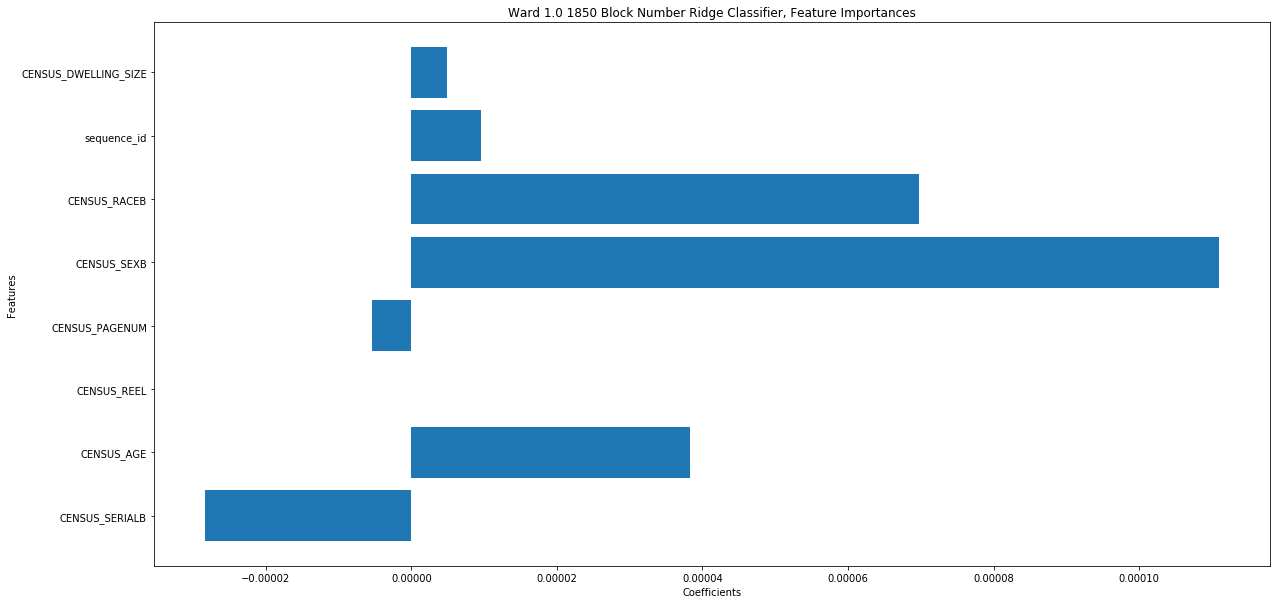

Model Trained for Ward 2.0
Total data available: 2894
Training Score: 0.18064516129032257
1850 Test Score: 0.13950276243093923 



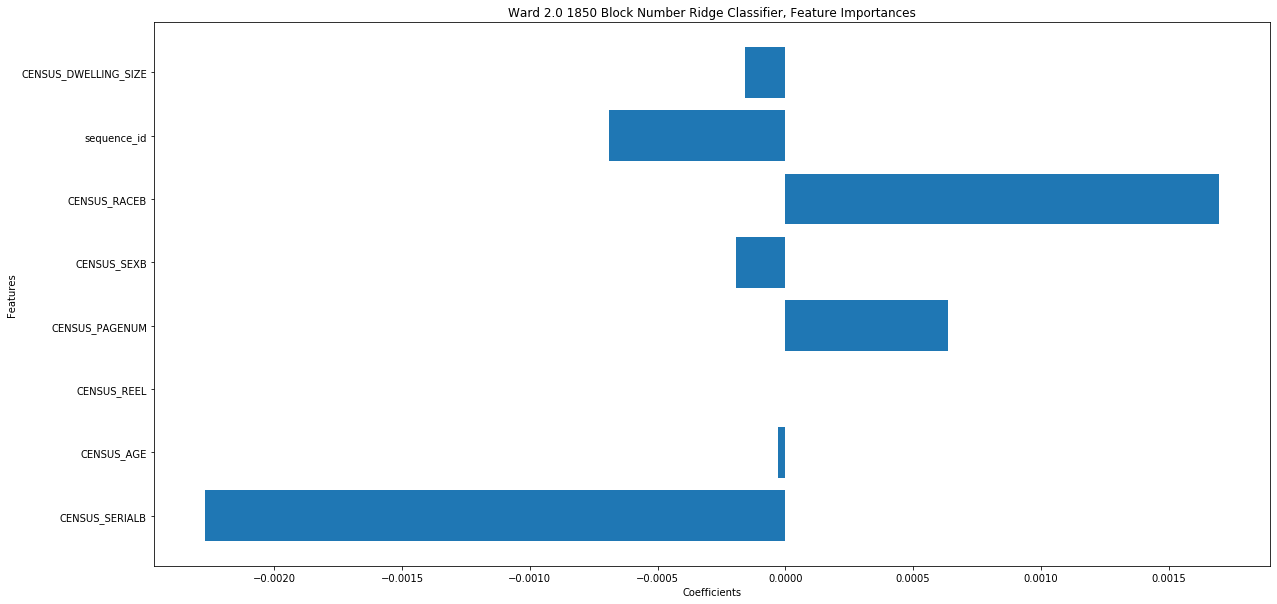

Model Trained for Ward 3.0
Total data available: 2798
Training Score: 0.29837940896091514
1850 Test Score: 0.2814285714285714 



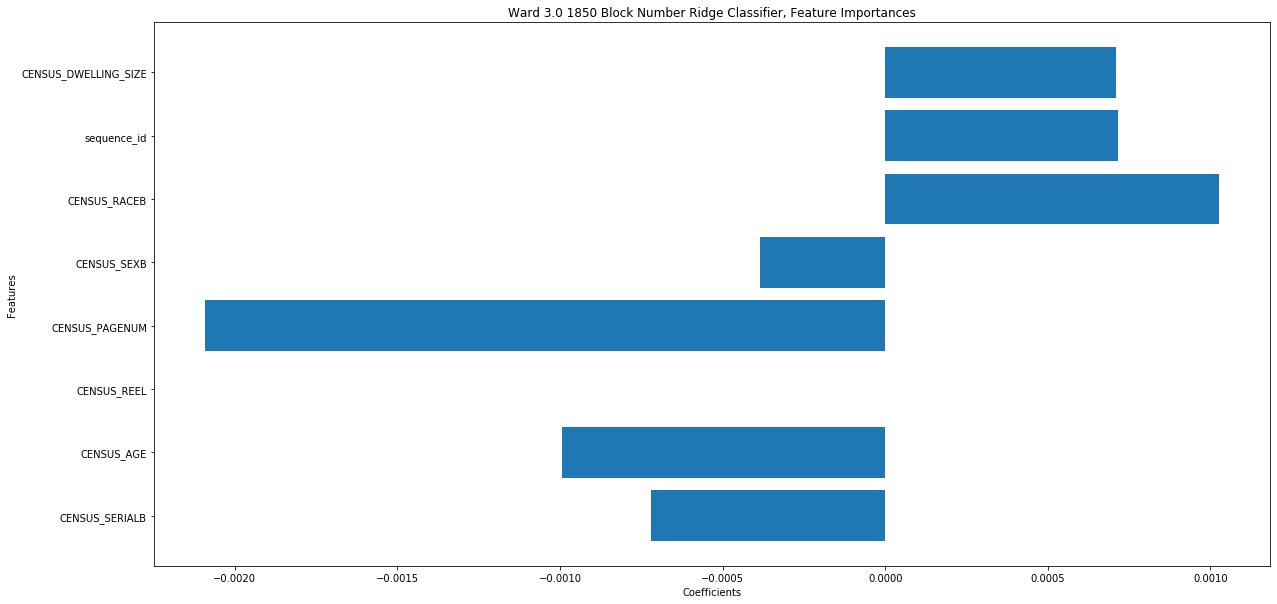

Model Trained for Ward 4.0
Total data available: 13276
Training Score: 0.17455056743999198
1850 Test Score: 0.1515516721904188 



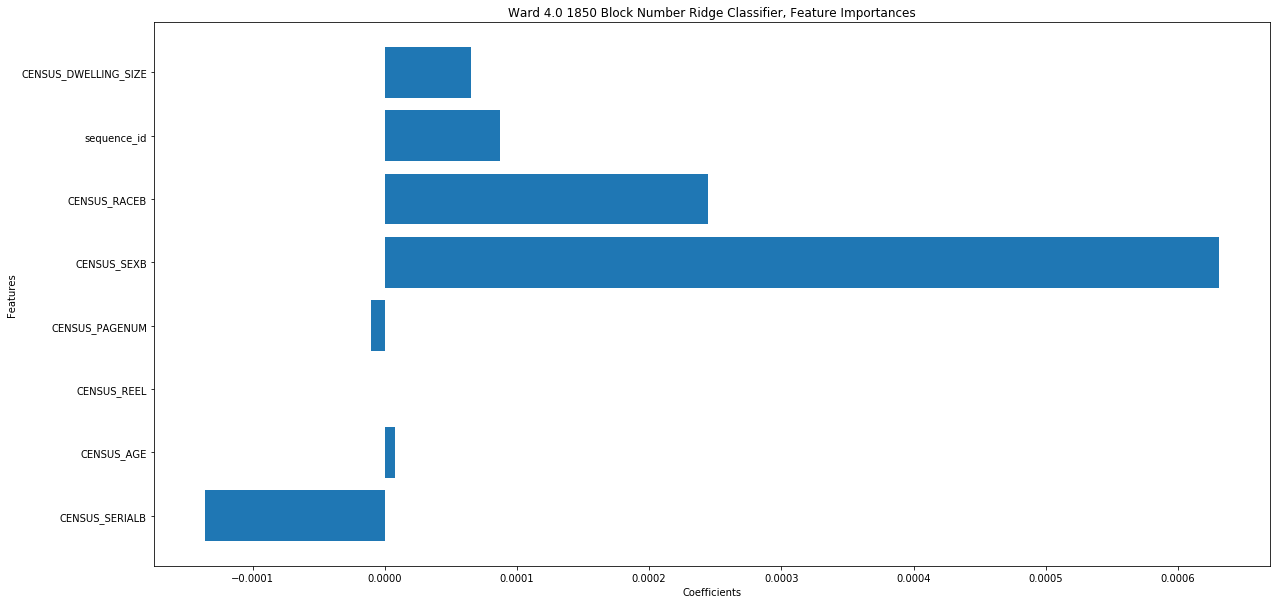

Model Trained for Ward 5.0
Total data available: 12725
Training Score: 0.11830661217646442
1850 Test Score: 0.10905091137649277 



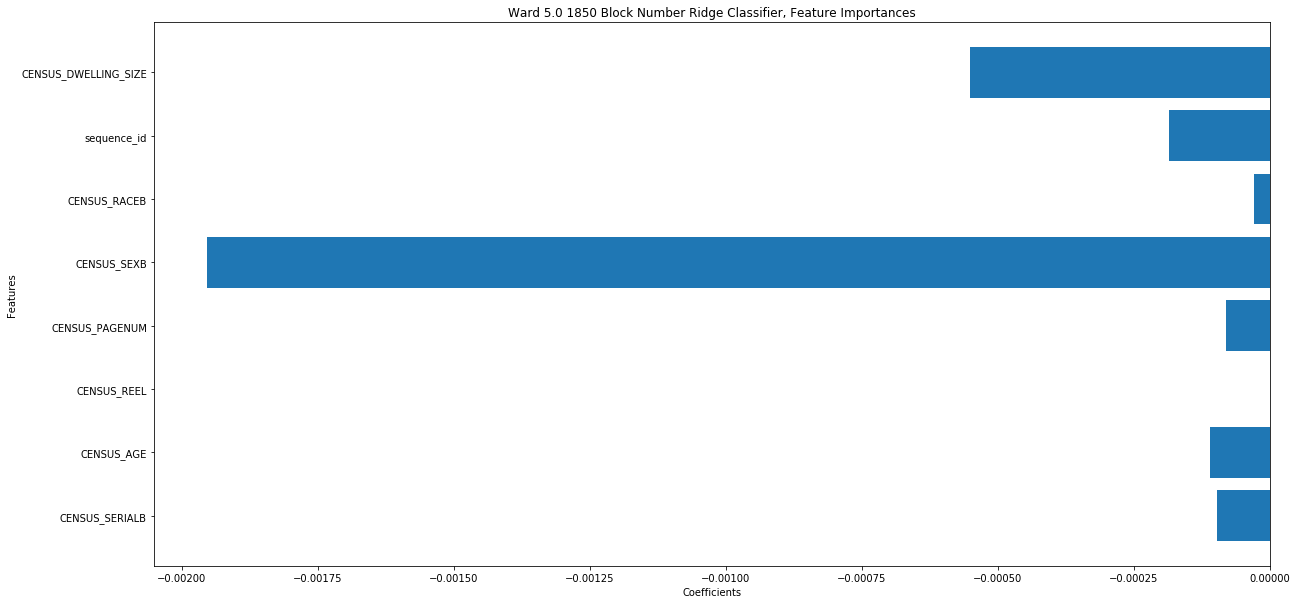

Model Trained for Ward 6.0
Total data available: 12291
Training Score: 0.20774571490561944
1850 Test Score: 0.19720143182557762 



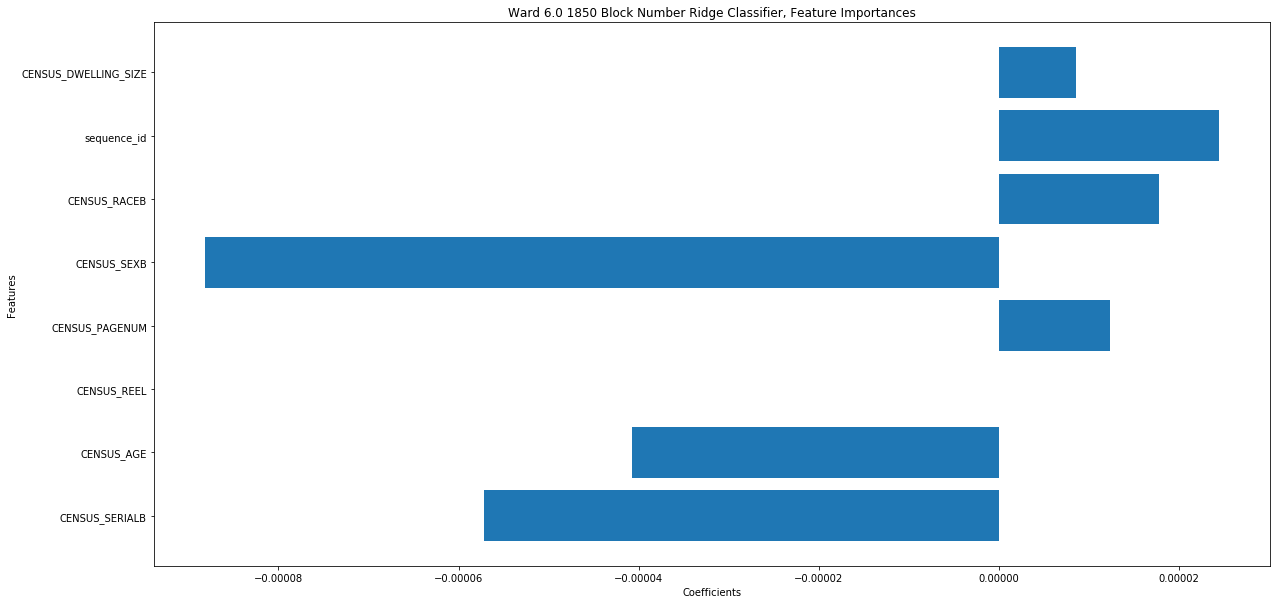

Model Trained for Ward 7.0
Total data available: 19519
Training Score: 0.13224947059225356
1850 Test Score: 0.12192622950819672 



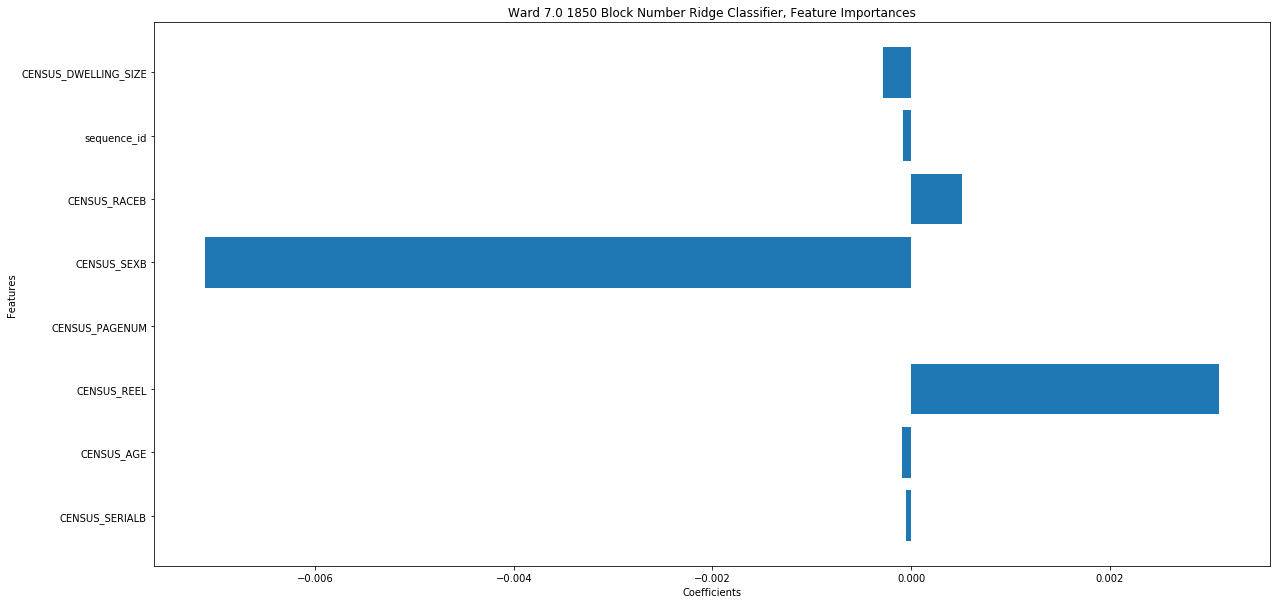

Model Trained for Ward 8.0
Total data available: 23790
Training Score: 0.14762918955274074
1850 Test Score: 0.1472763954270343 



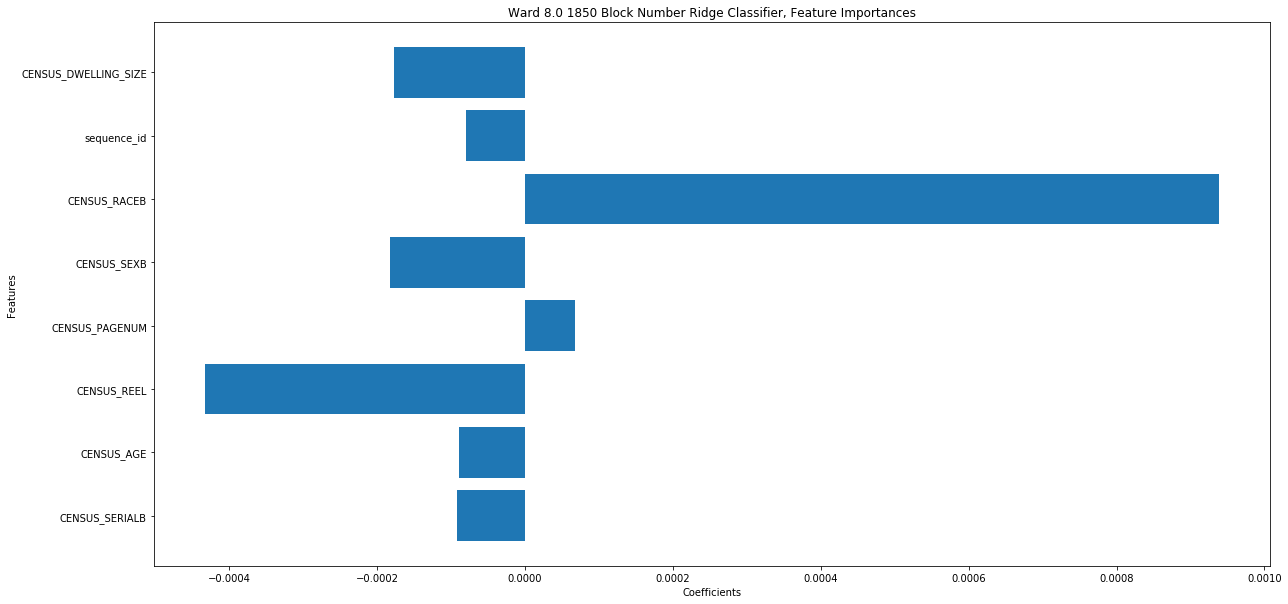

Model Trained for Ward 9.0
Total data available: 28188
Training Score: 0.08925784021569462
1850 Test Score: 0.091812118632042 



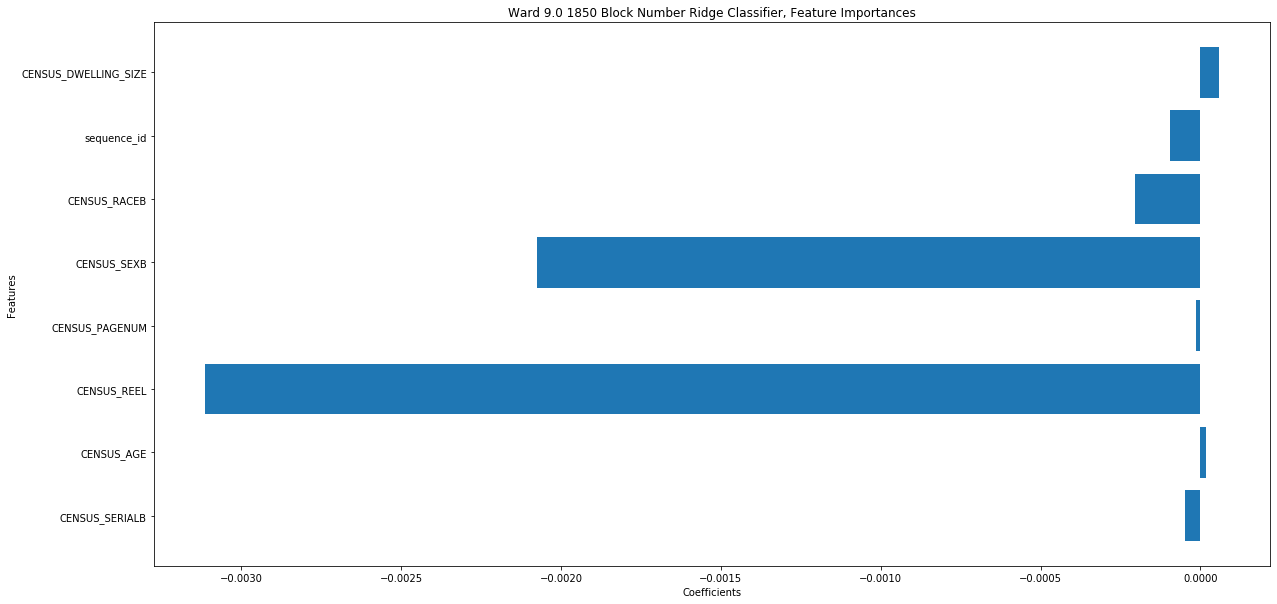

Model Trained for Ward 10.0
Total data available: 9391
Training Score: 0.17123384921198354
1850 Test Score: 0.14821124361158433 



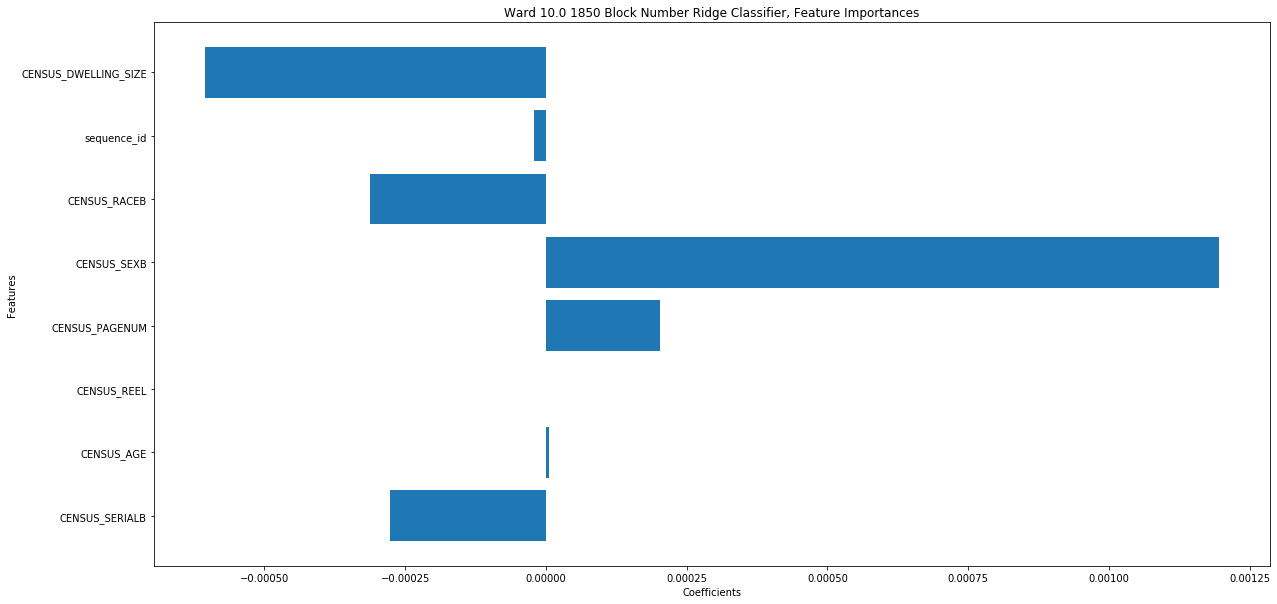

Model Trained for Ward 11.0
Total data available: 17044
Training Score: 0.1258702964875225
1850 Test Score: 0.12602675428303214 



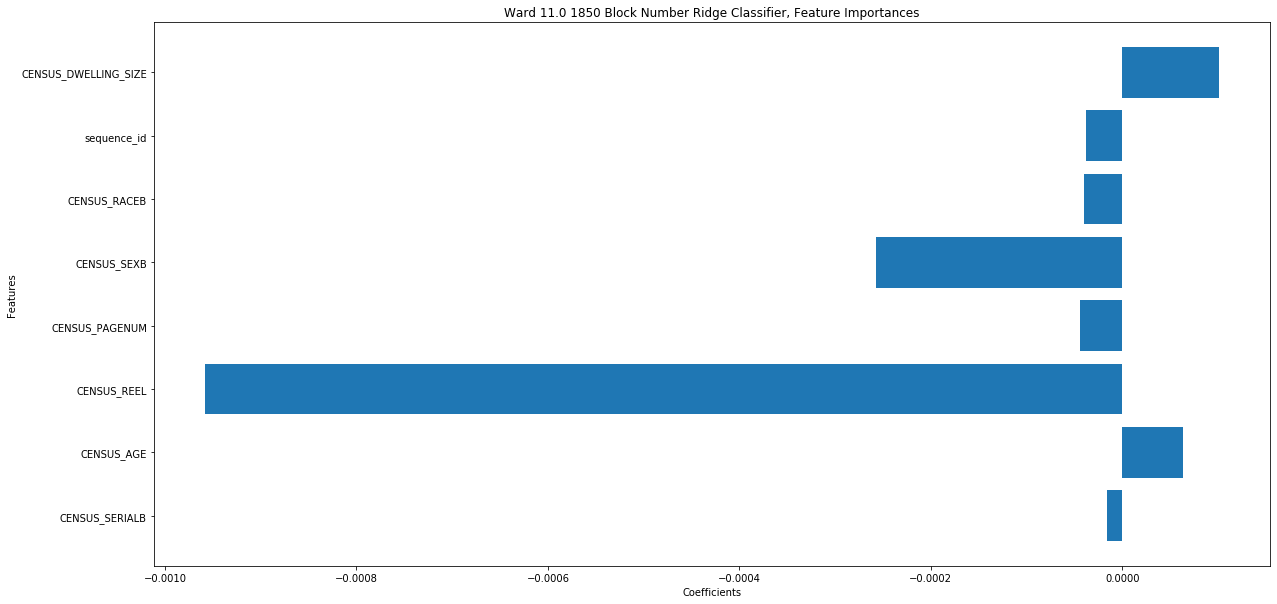

Model Trained for Ward 13.0
Total data available: 17828
Training Score: 0.16722758208062224
1850 Test Score: 0.16176800538478797 



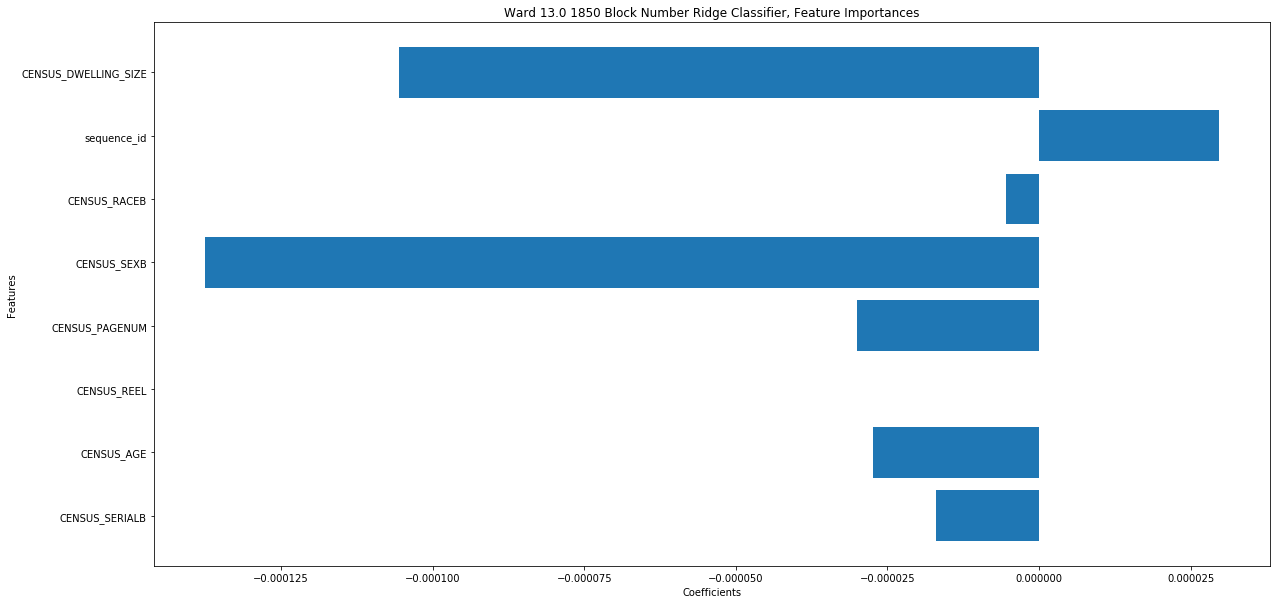

Model Trained for Ward 14.0
Total data available: 15270
Training Score: 0.25881942018861337
1850 Test Score: 0.24567836563645887 



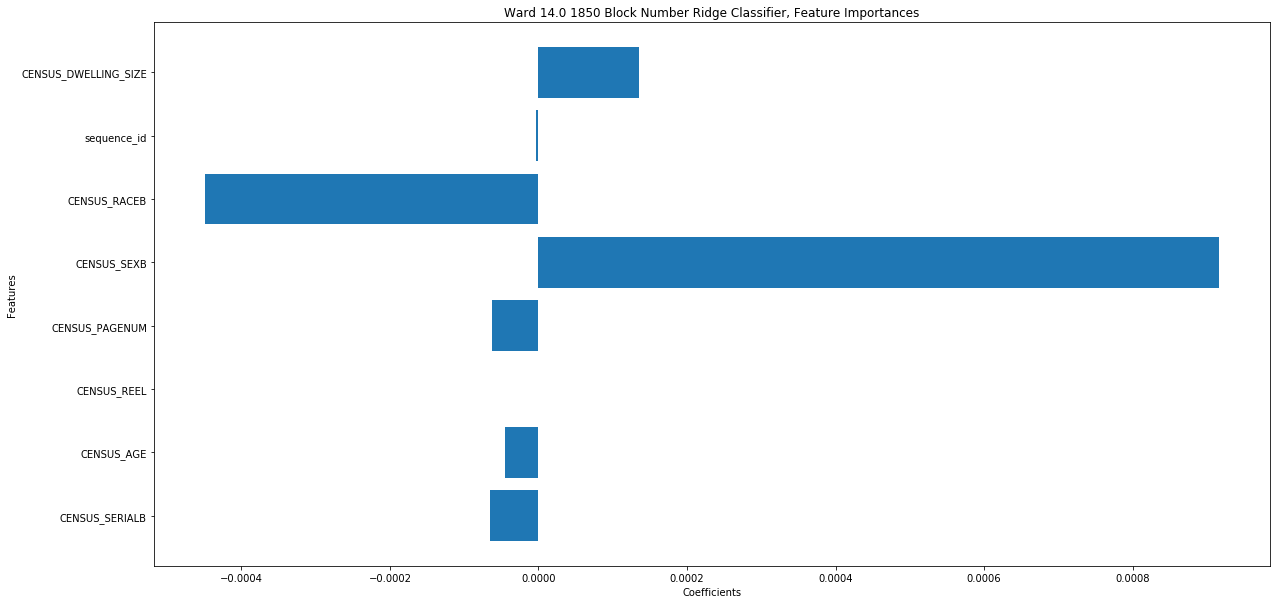

Model Trained for Ward 15.0
Total data available: 8607
Training Score: 0.17753679318357862
1850 Test Score: 0.17146840148698886 



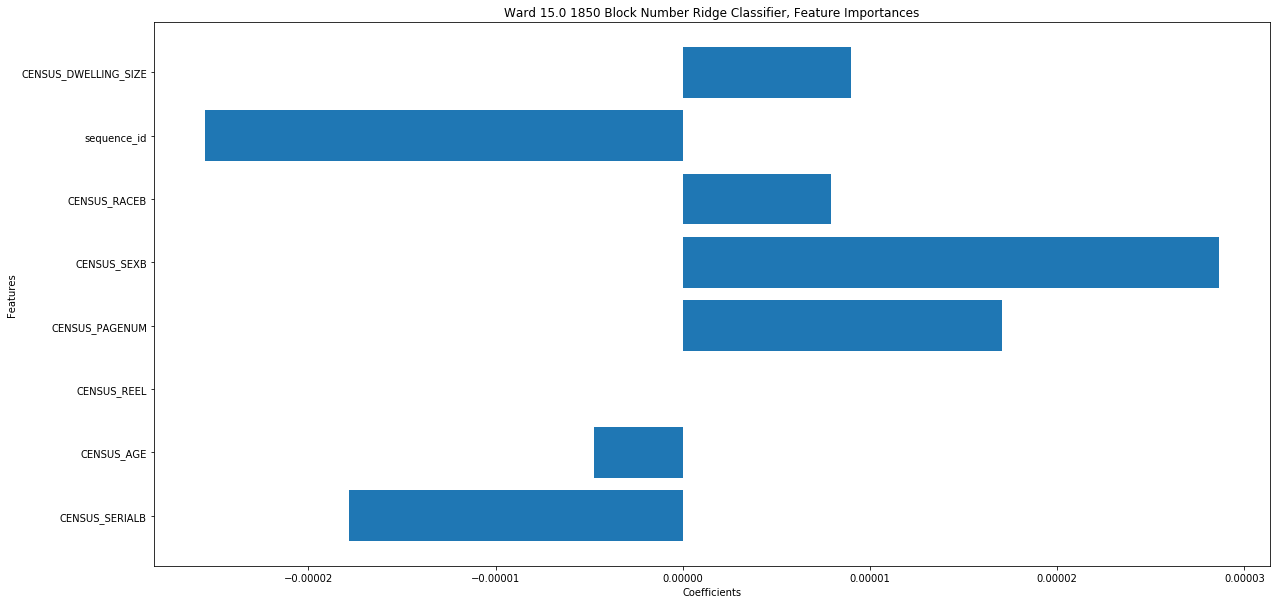

Model Trained for Ward 16.0
Total data available: 31140
Training Score: 0.10631556411903233
1850 Test Score: 0.09646756583172768 



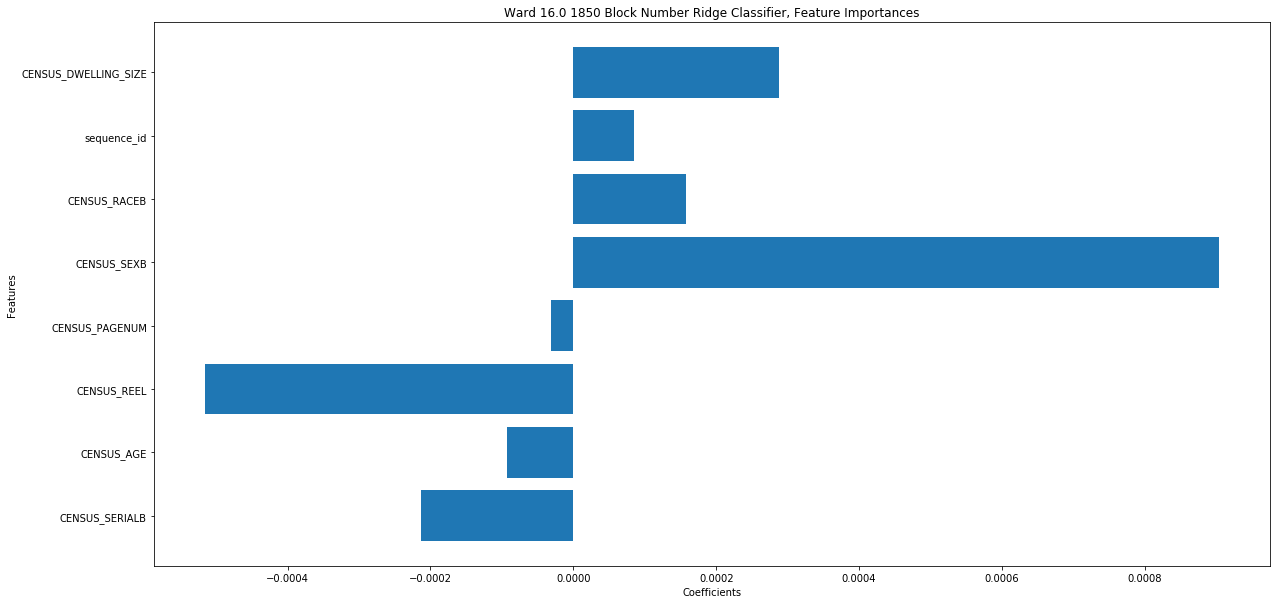

Model Trained for Ward 17.0
Total data available: 23133
Training Score: 0.14669433396737563
1850 Test Score: 0.14107883817427386 



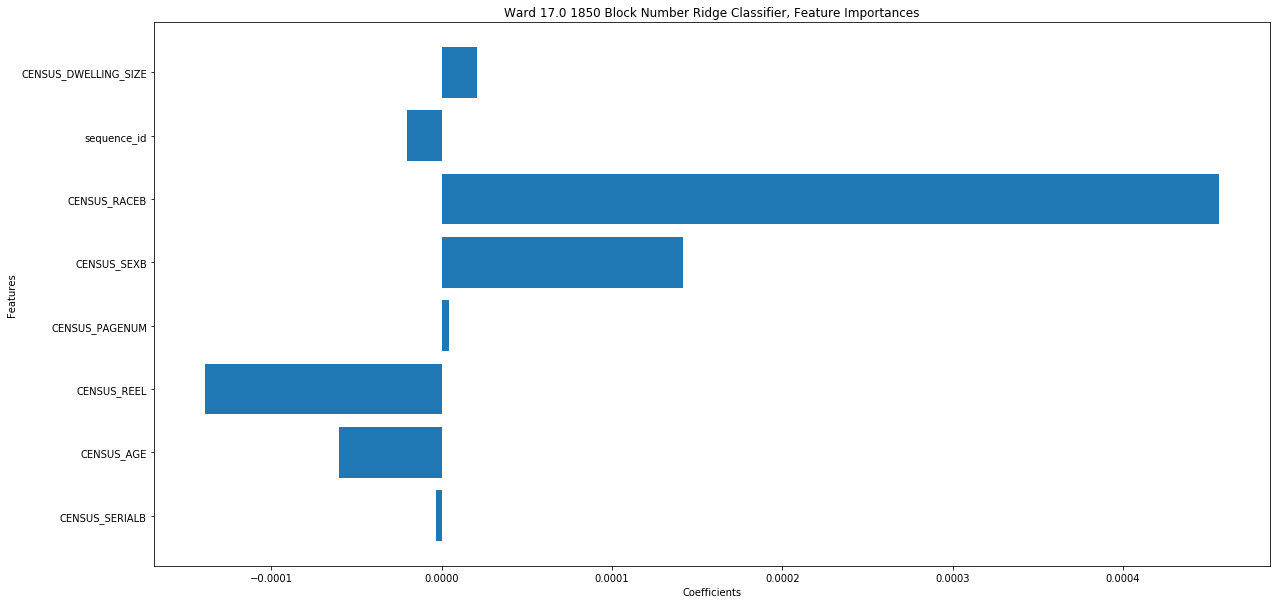

Model Trained for Ward 18.0
Total data available: 9943
Training Score: 0.17741719190022798
1850 Test Score: 0.1753821399839099 



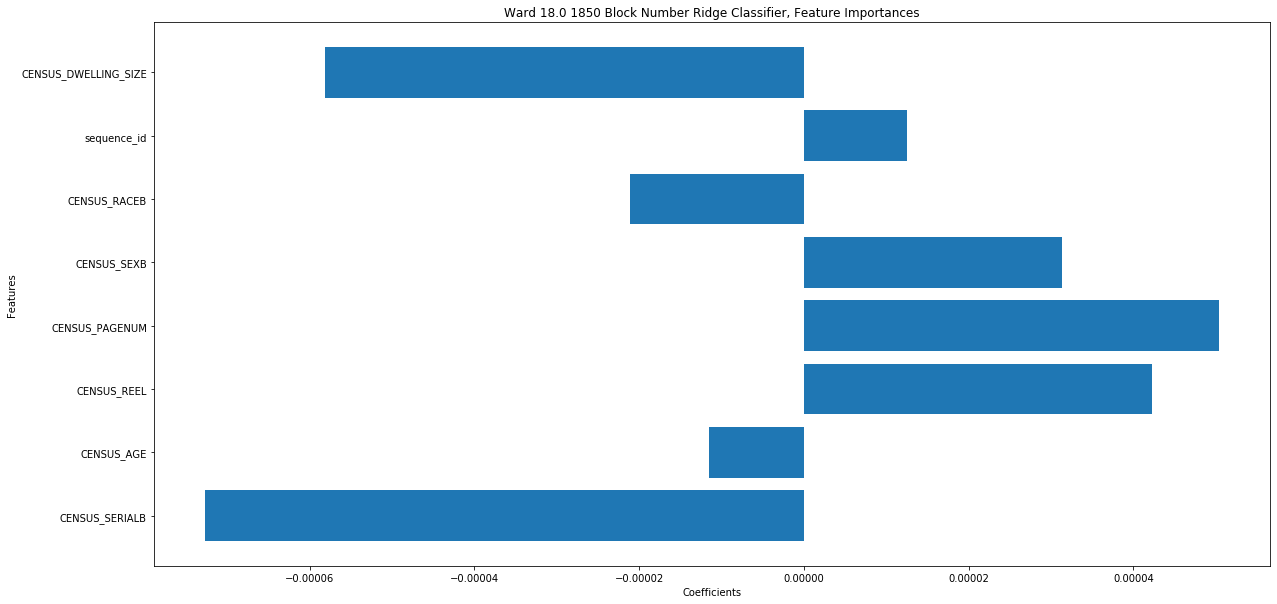

Model Trained for Ward 19.0
Total data available: 58
Training Score: 1.0
1850 Test Score: 1.0 



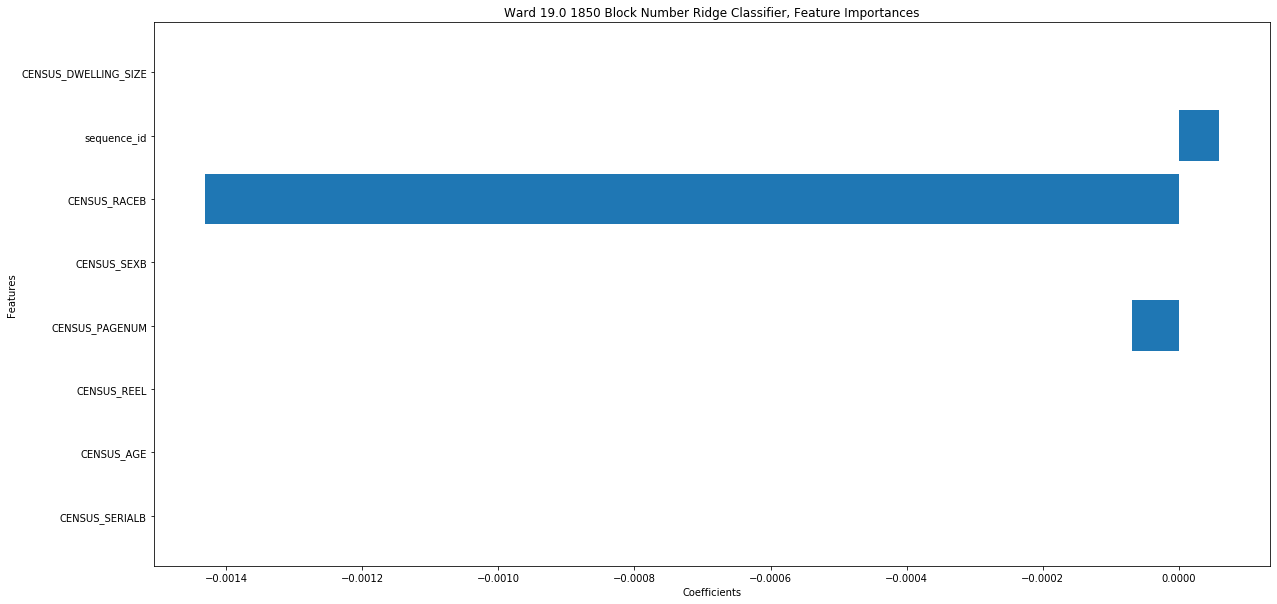

In [43]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE"]

for ward in dwellings_1850.WARD_NUM.unique():
    df = census_1850_model[census_1850_model["WARD_NUM"] == ward]
    train_X, test_X, train_y, test_y = train_test_split(df.loc[:,all_cols], df.loc[:, "block_num"])
    ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                             ('classifier', RidgeClassifier())])
    ridge_class.fit(train_X, train_y)
    print("Model Trained for Ward " + str(ward))
    print("Total data available:", len(df))
    print("Training Score:", ridge_class.score(train_X, train_y))
    print("1850 Test Score:", ridge_class.score(test_X, test_y), "\n")
    interpolation.graph_coefs(ridge_class.named_steps['preprocess'].get_feature_names(), ridge_class.named_steps['classifier'].coef_[0], "Ward "+str(ward)+ " 1850 Block Number Ridge Classifier, Feature Importances")

Model Trained for Ward 1.0
Total data available: 302
Training Score: 0.1415929203539823
1850 Test Score: 0.039473684210526314 



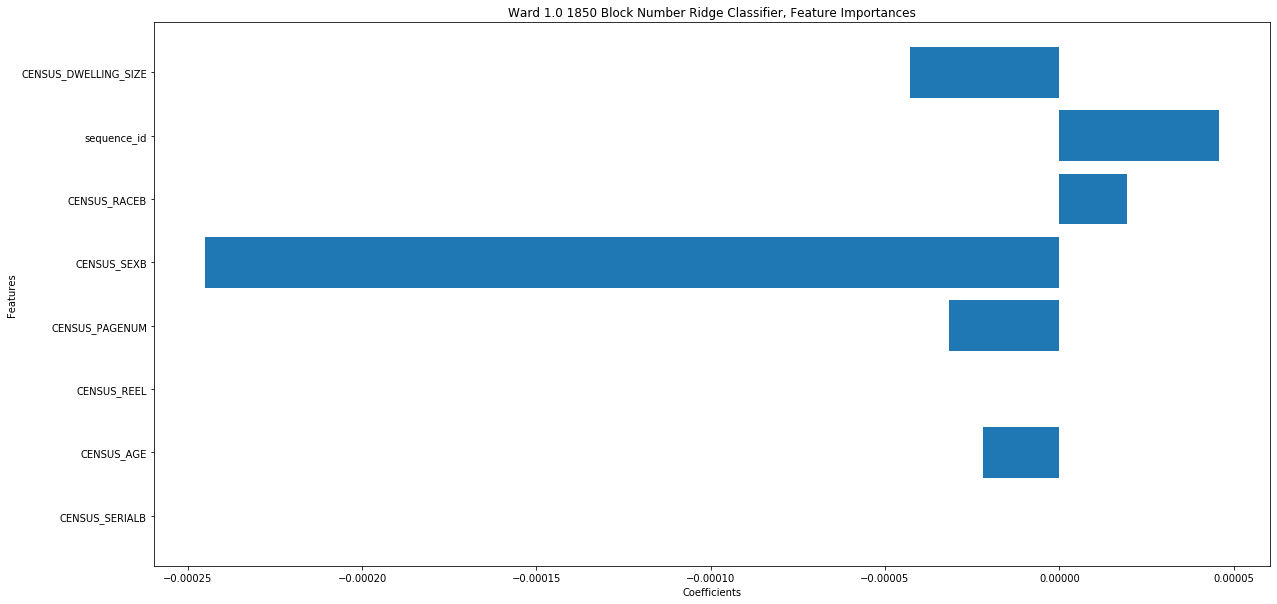

Model Trained for Ward 2.0
Total data available: 105
Training Score: 0.23076923076923078
1850 Test Score: 0.07407407407407407 



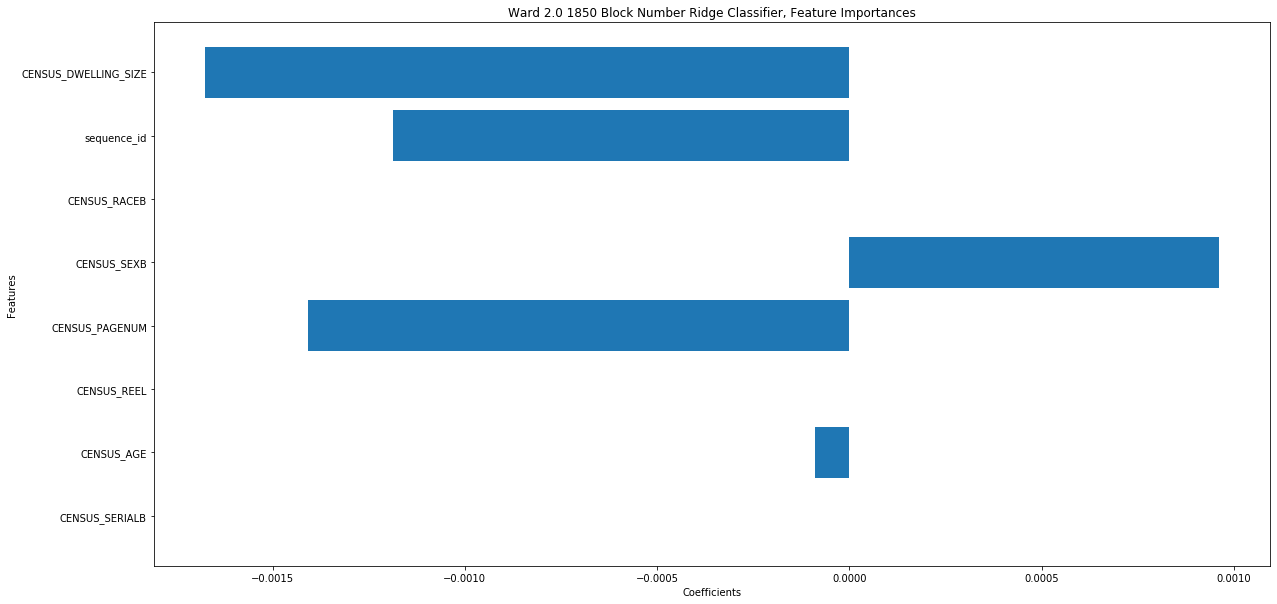

Model Trained for Ward 3.0
Total data available: 127
Training Score: 0.23157894736842105
1850 Test Score: 0.03125 



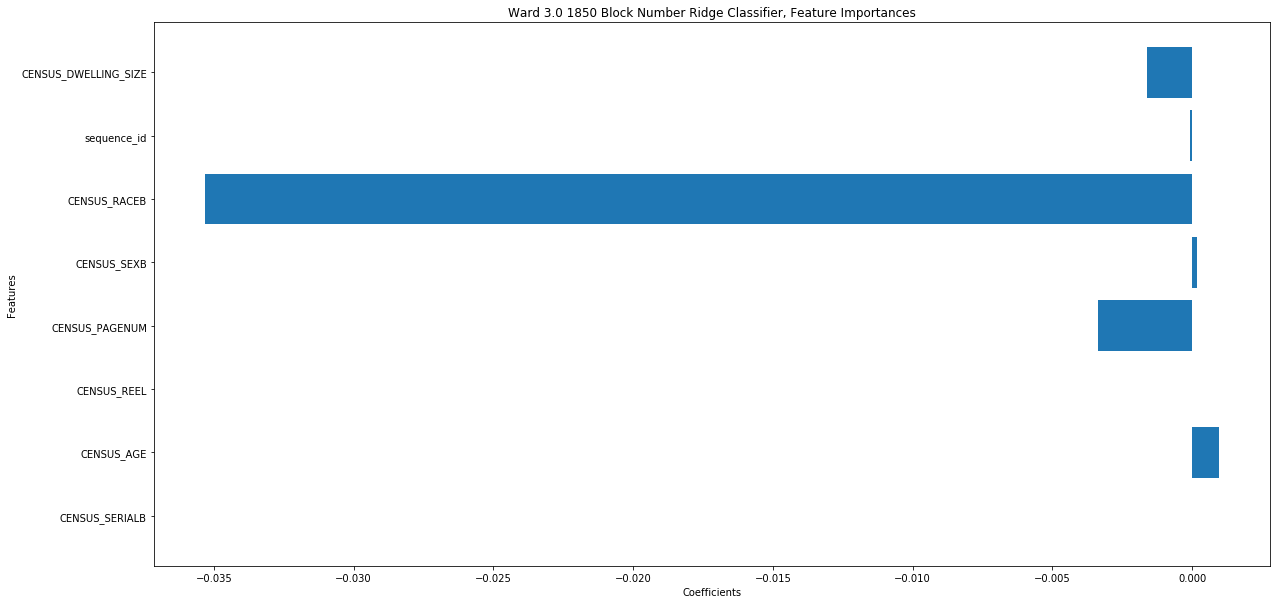

Model Trained for Ward 4.0
Total data available: 345
Training Score: 0.1511627906976744
1850 Test Score: 0.09195402298850575 



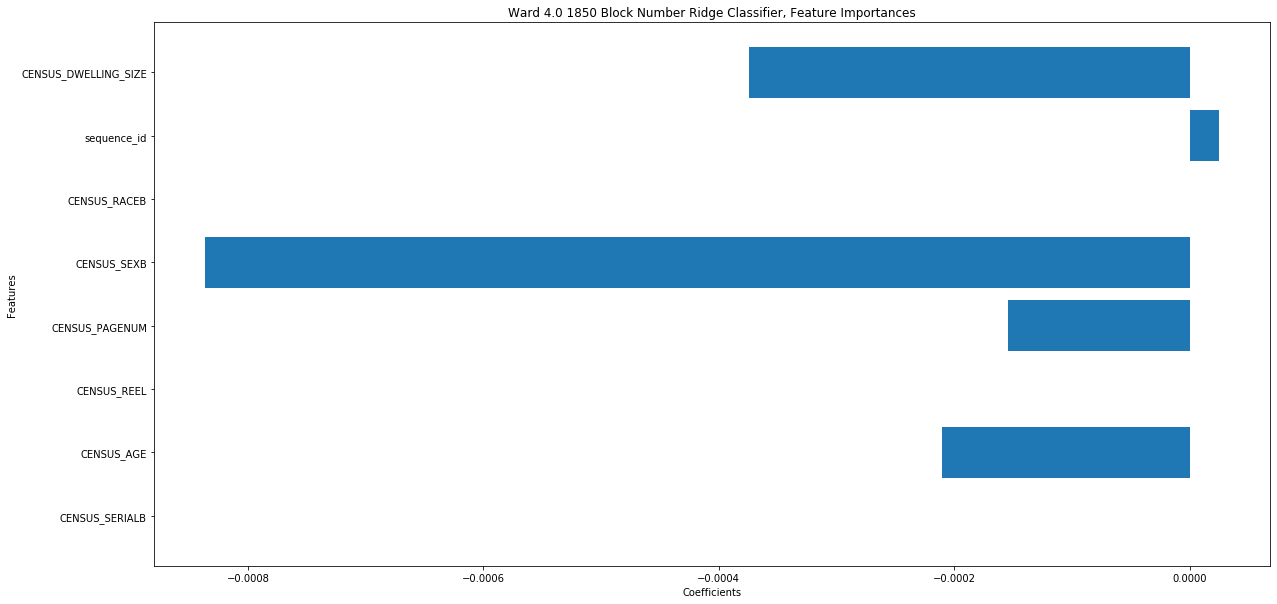

Model Trained for Ward 5.0
Total data available: 510
Training Score: 0.12303664921465969
1850 Test Score: 0.03125 



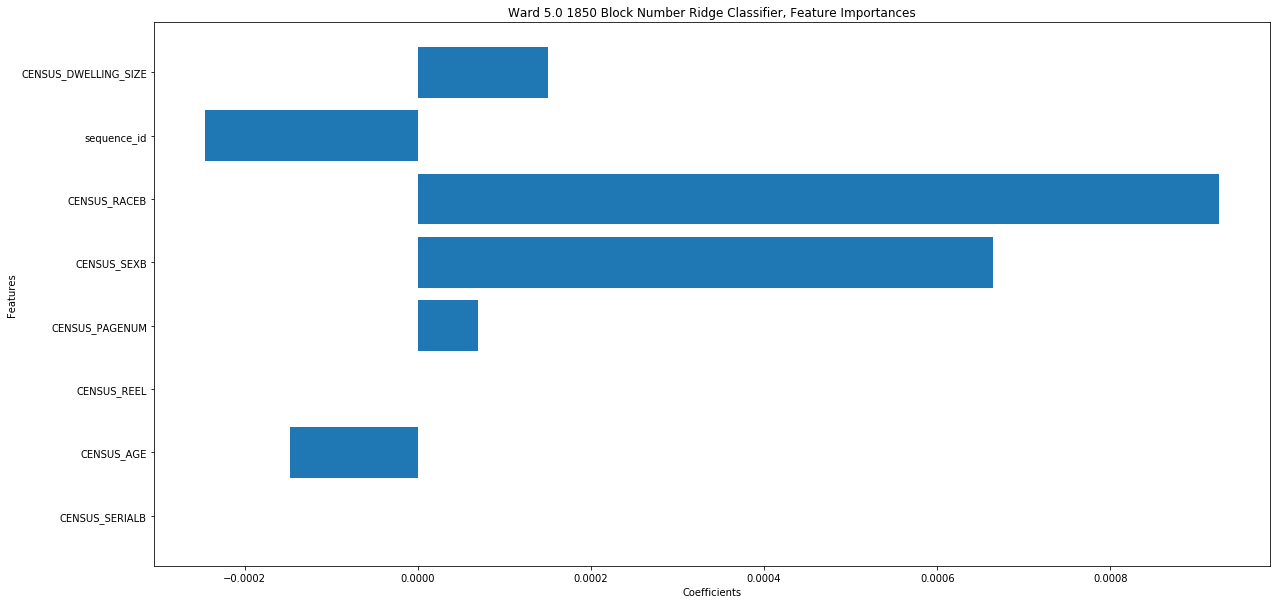

Model Trained for Ward 6.0
Total data available: 302
Training Score: 0.1902654867256637
1850 Test Score: 0.05263157894736842 



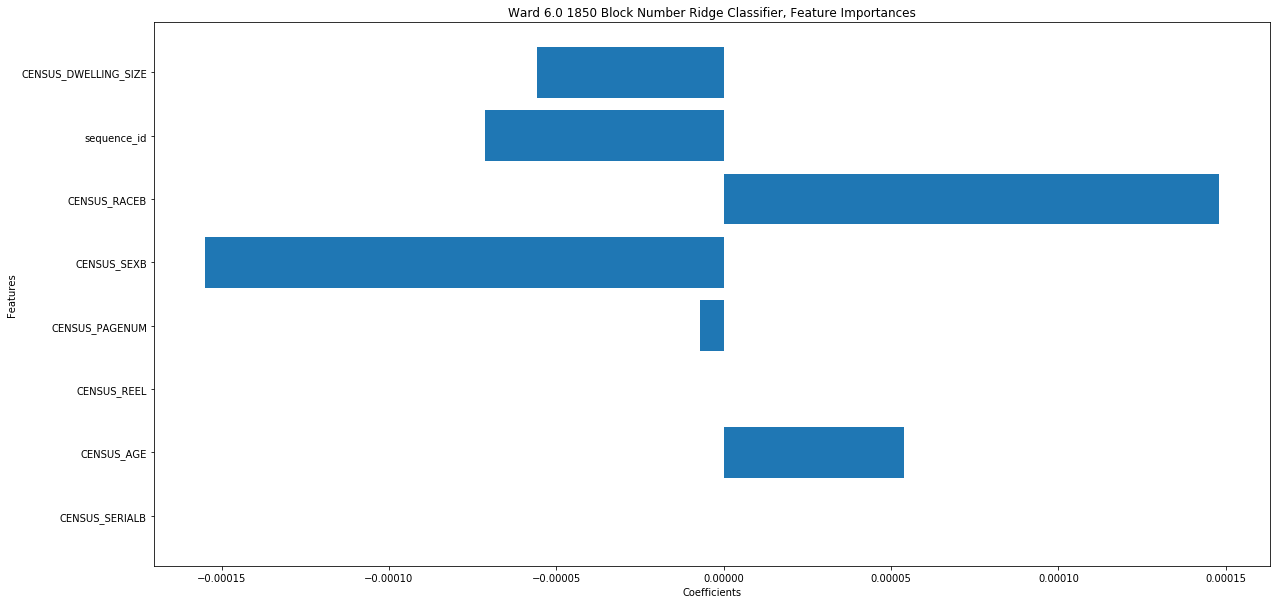

Model Trained for Ward 7.0
Total data available: 616
Training Score: 0.1341991341991342
1850 Test Score: 0.01948051948051948 



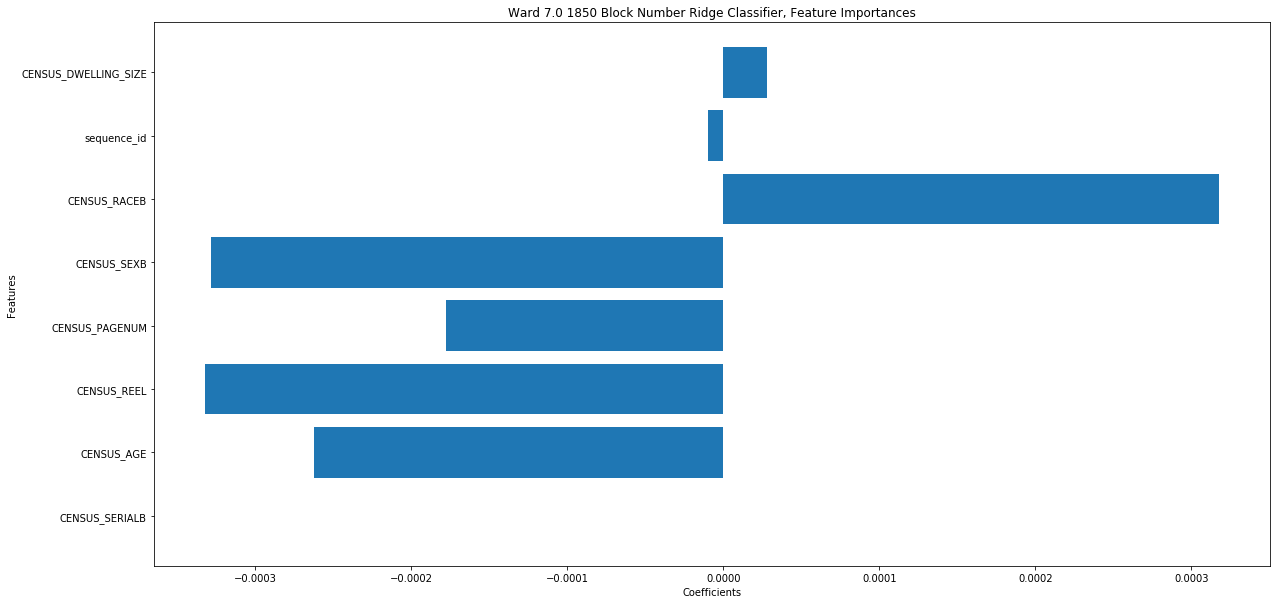

Model Trained for Ward 8.0
Total data available: 666
Training Score: 0.11623246492985972
1850 Test Score: 0.059880239520958084 



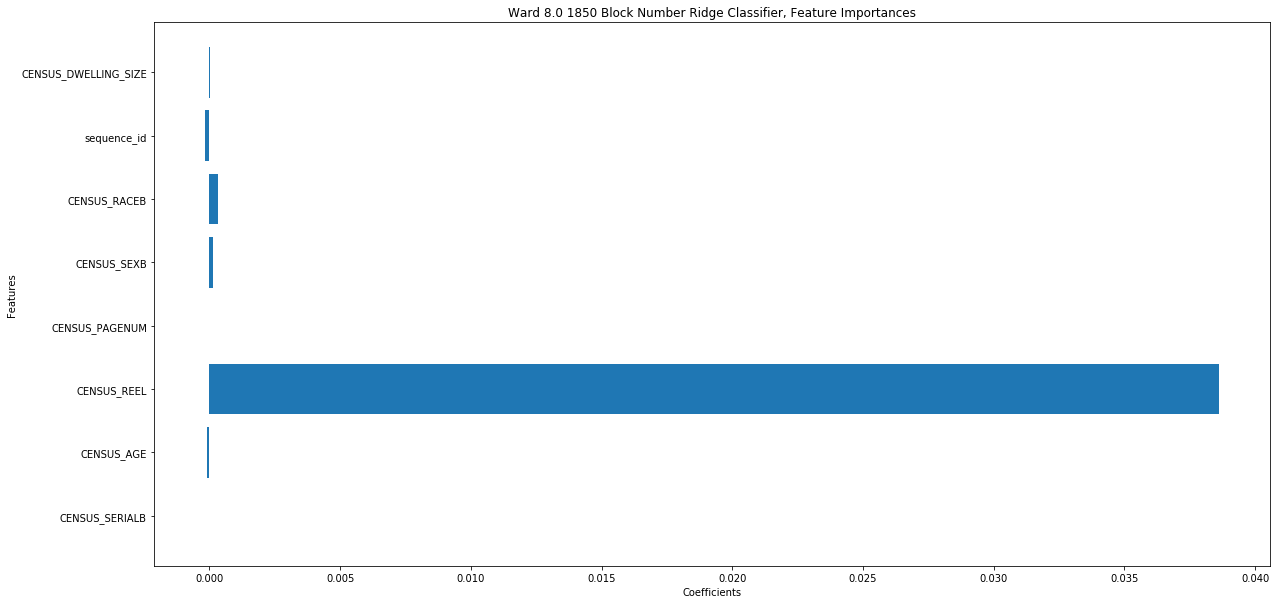

Model Trained for Ward 9.0
Total data available: 813
Training Score: 0.08045977011494253
1850 Test Score: 0.06372549019607843 



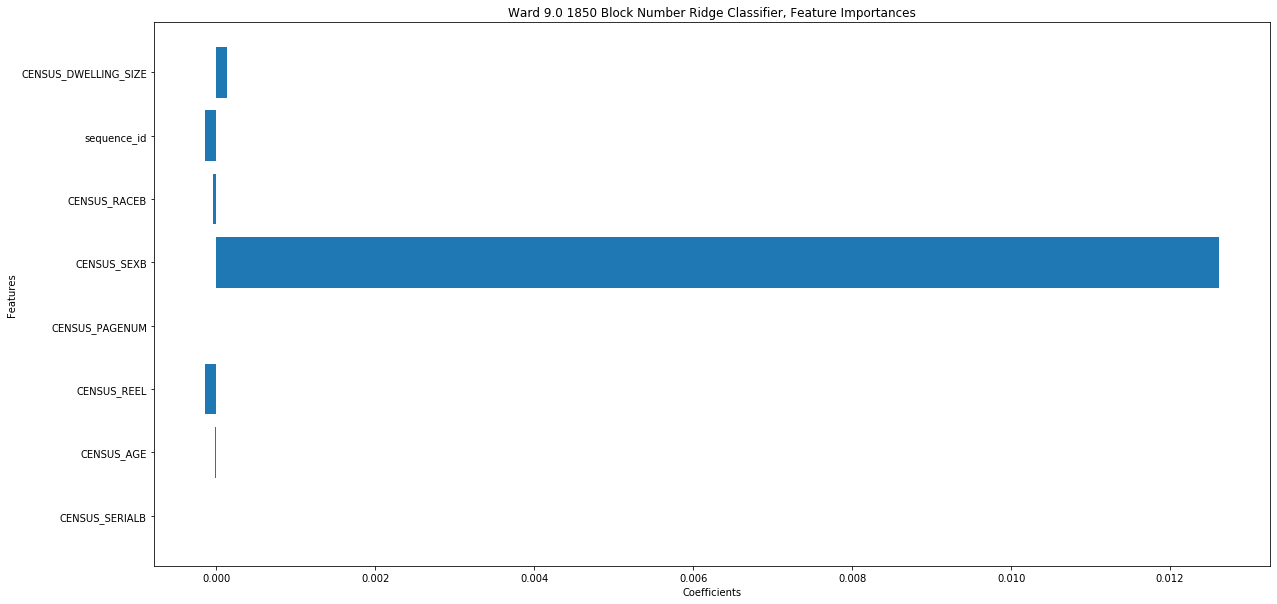

Model Trained for Ward 10.0
Total data available: 378
Training Score: 0.15901060070671377
1850 Test Score: 0.07368421052631578 



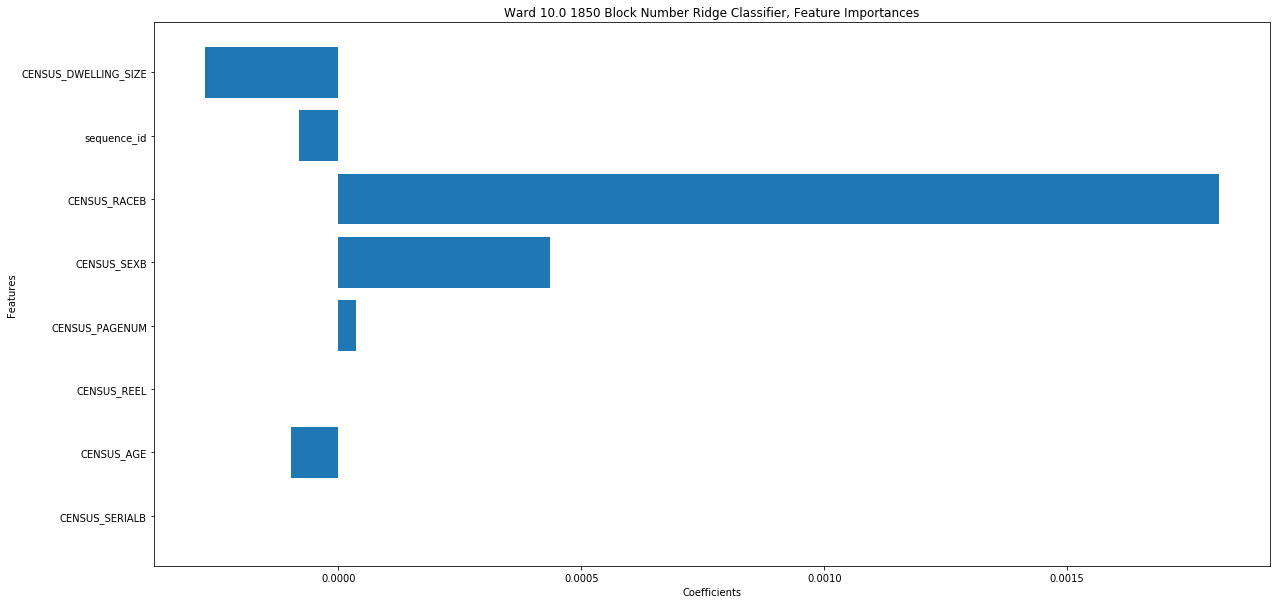

Model Trained for Ward 11.0
Total data available: 329
Training Score: 0.17073170731707318
1850 Test Score: 0.07228915662650602 



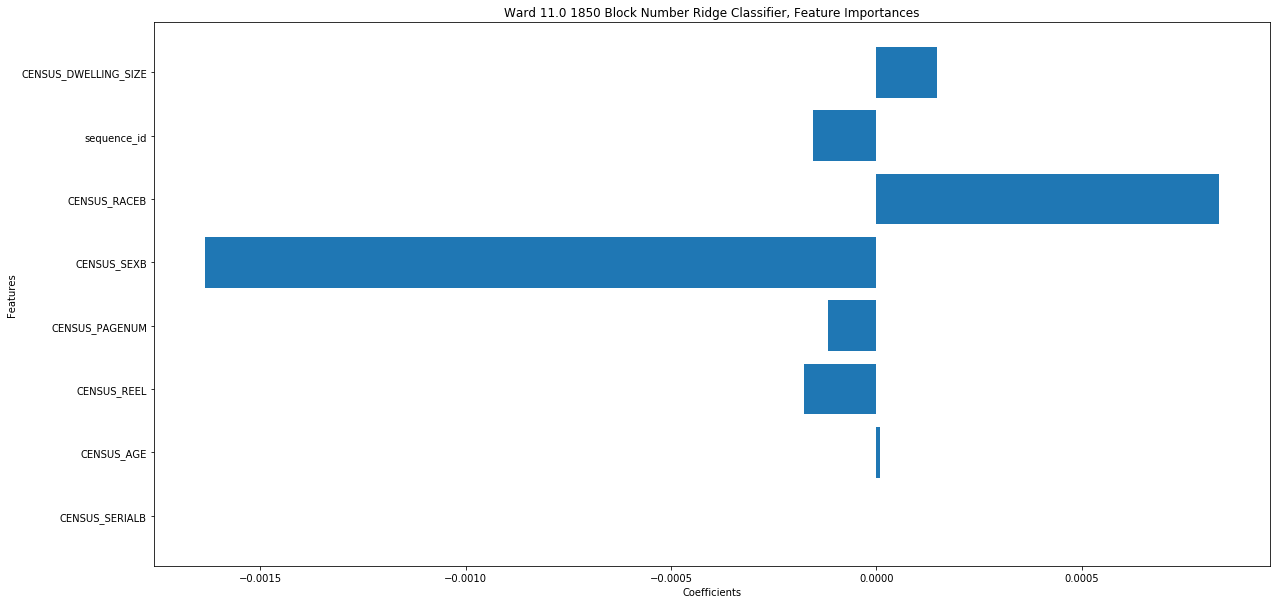

Model Trained for Ward 13.0
Total data available: 557
Training Score: 0.14388489208633093
1850 Test Score: 0.10714285714285714 



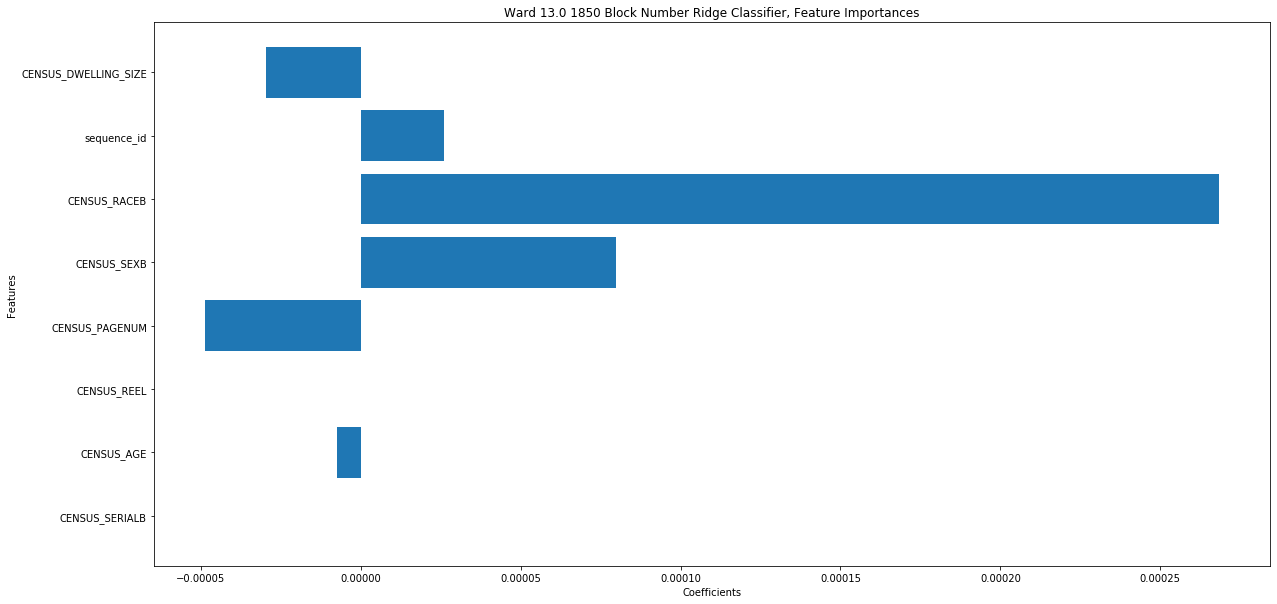

Model Trained for Ward 14.0
Total data available: 463
Training Score: 0.207492795389049
1850 Test Score: 0.13793103448275862 



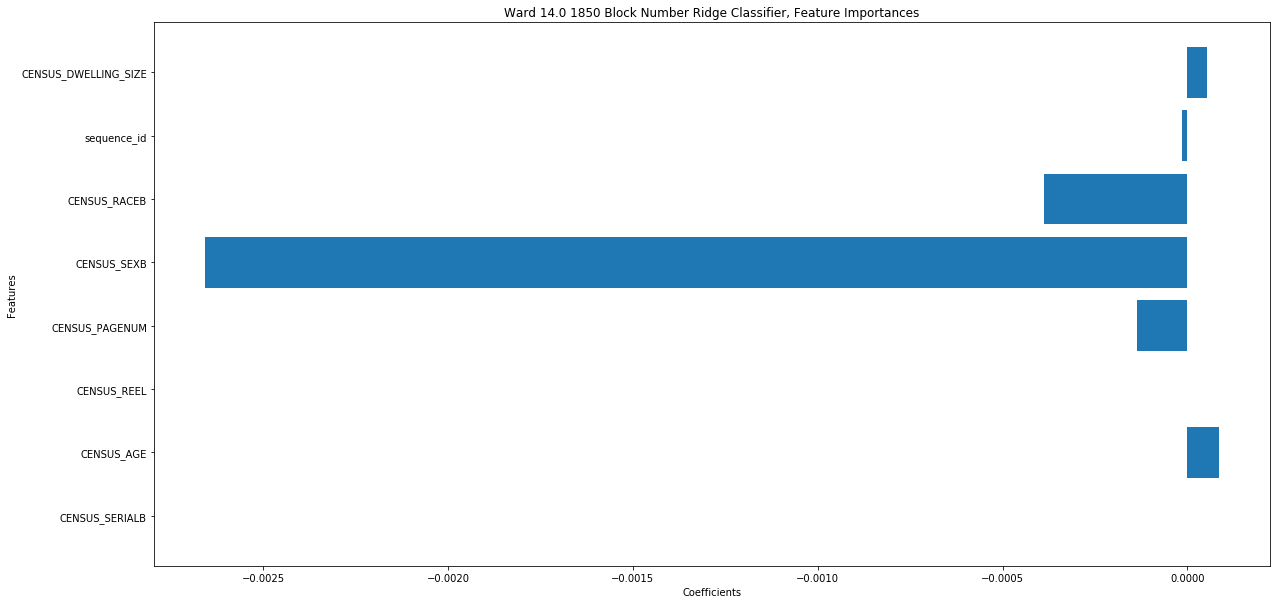

Model Trained for Ward 15.0
Total data available: 400
Training Score: 0.15
1850 Test Score: 0.05 



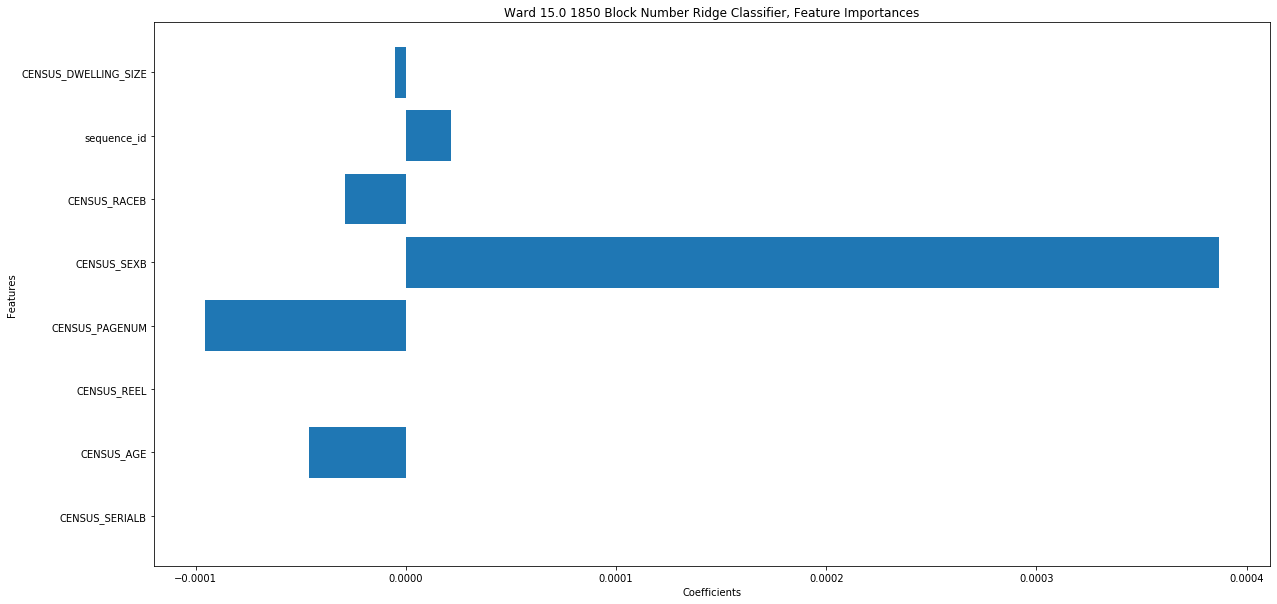

Model Trained for Ward 16.0
Total data available: 864
Training Score: 0.125
1850 Test Score: 0.037037037037037035 



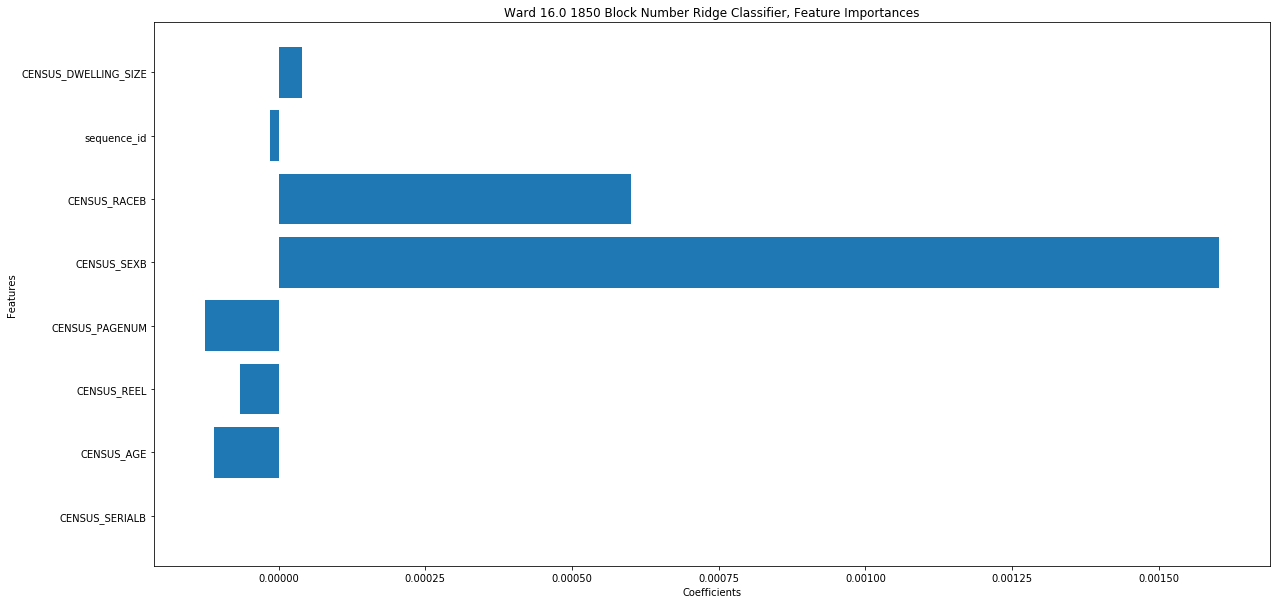

Model Trained for Ward 17.0
Total data available: 464
Training Score: 0.13793103448275862
1850 Test Score: 0.0603448275862069 



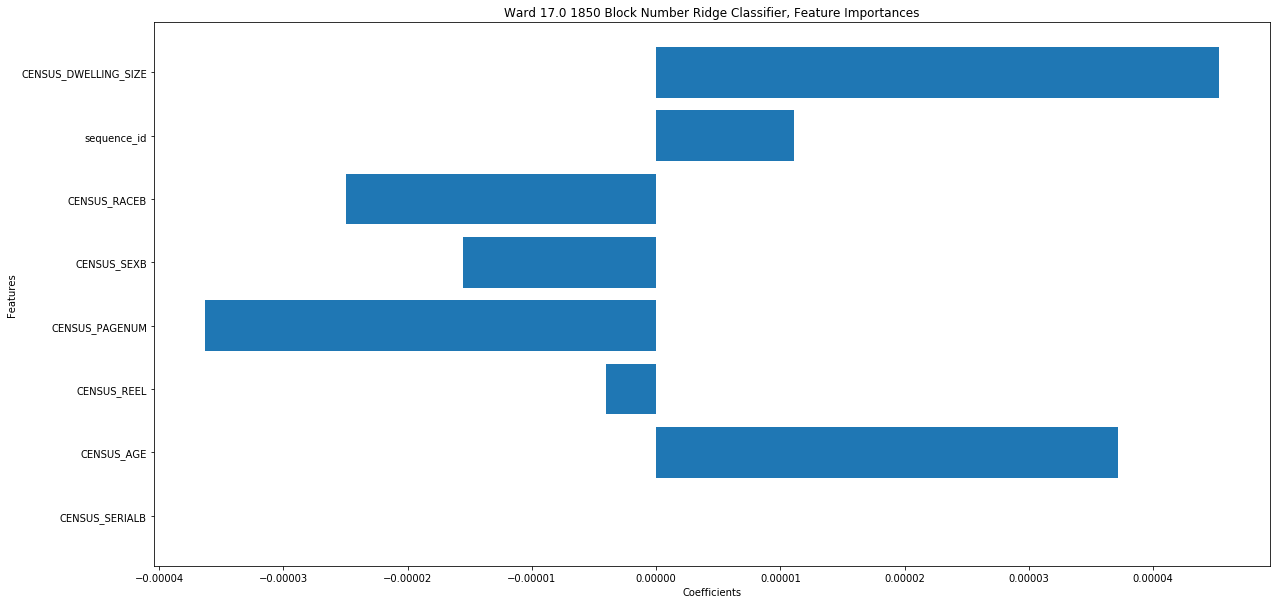

Model Trained for Ward 18.0
Total data available: 280
Training Score: 0.14285714285714285
1850 Test Score: 0.014285714285714285 



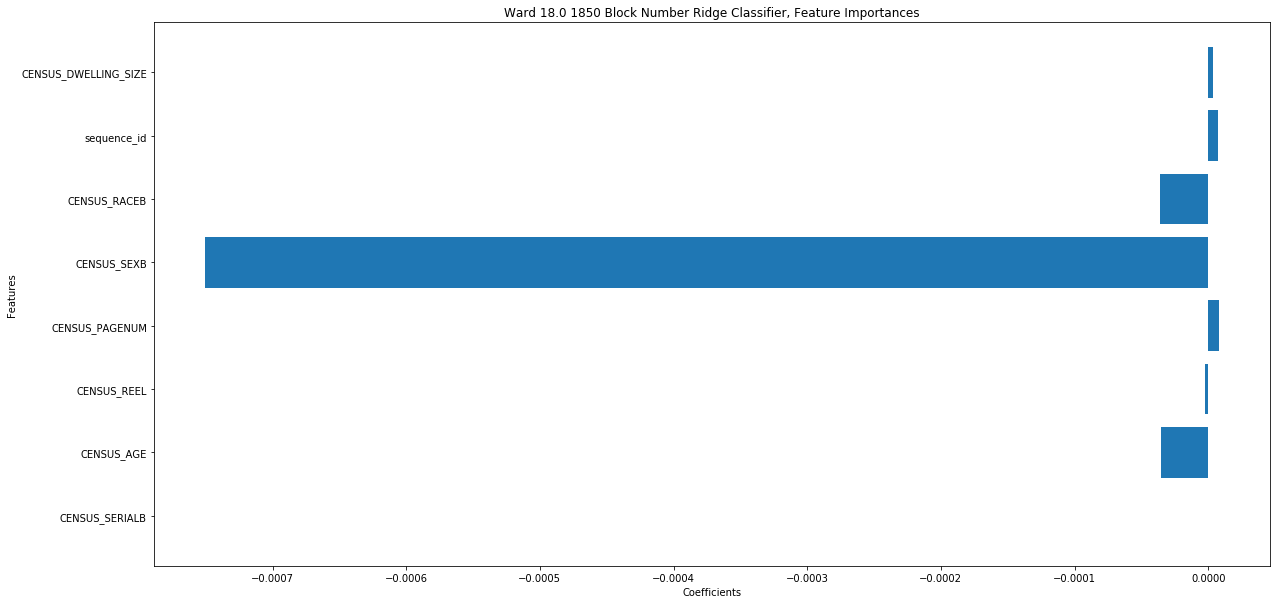

ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [50]:
#want to try this with dwelling level, okay this does not improve things
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE"]

for ward in dwellings_1850.WARD_NUM.unique():
    df = dwellings_1850[dwellings_1850["WARD_NUM"] == ward]
    train_X, test_X, train_y, test_y = train_test_split(df.loc[:,all_cols], df.loc[:, "block_num"])
    ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                             ('classifier', RidgeClassifier())])
    ridge_class.fit(train_X, train_y)
    print("Model Trained for Ward " + str(ward))
    print("Total data available:", len(df))
    print("Training Score:", ridge_class.score(train_X, train_y))
    print("1850 Test Score:", ridge_class.score(test_X, test_y), "\n")
    interpolation.graph_coefs(ridge_class.named_steps['preprocess'].get_feature_names(), ridge_class.named_steps['classifier'].coef_[0], "Ward "+str(ward)+ " 1850 Block Number Ridge Classifier, Feature Importances")

So training entirely on 1850 works better, but not perfectly. Aside from ward 19, I think training on just 1850, is fine with how much data is available. This also makes sense conceptually because for example, demographics can shift majorly in 30 years. Also this way we can add in features that only exist in 1850.
So Ward 14 matters the most, let's take a look at the features importances for there.

In [44]:
df = census_1850_model[census_1850_model["WARD_NUM"] == 14]
train_X, test_X, train_y, test_y = train_test_split(df.loc[:,all_cols], df.loc[:, "block_num"])
ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', RidgeClassifier())])
ridge_class.fit(train_X, train_y)
print("Model Trained for Ward " + str(ward))
print("Training Score:", ridge_class.score(train_X, train_y))
print("1850 Test Score:", ridge_class.score(test_X, test_y))


Model Trained for Ward 19.0
Training Score: 0.2529689137268599
1850 Test Score: 0.26322682032477734


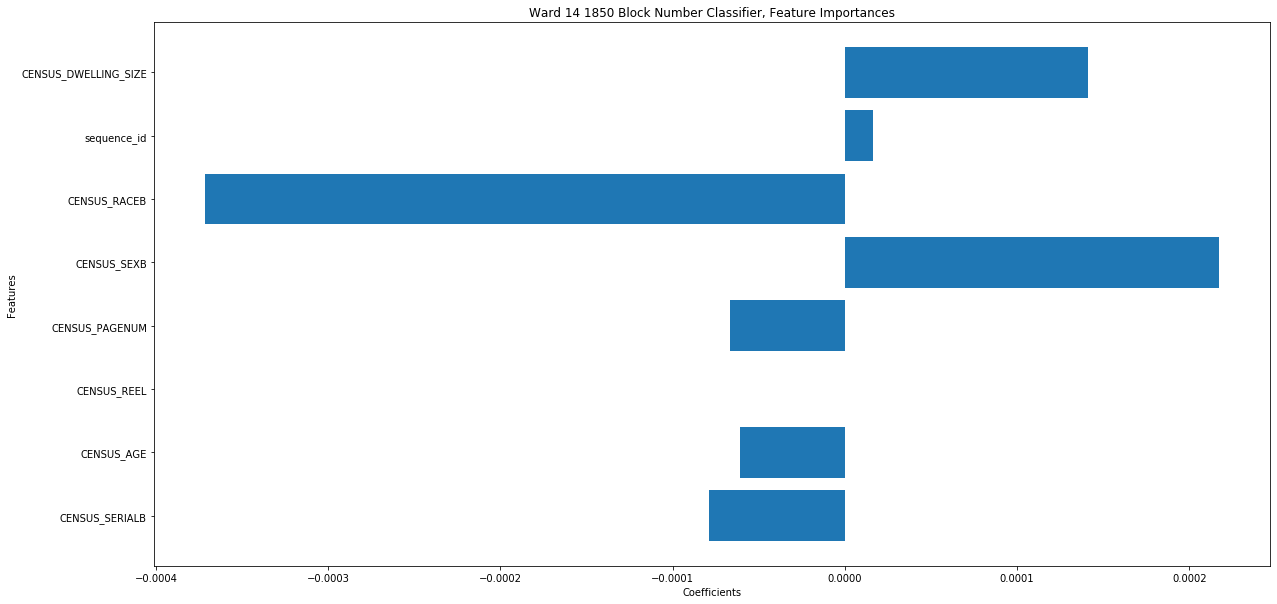

In [45]:
interpolation.graph_coefs(ridge_class.named_steps['preprocess'].get_feature_names(), ridge_class.named_steps['classifier'].coef_[0], "Ward 14 1850 Block Number Classifier, Feature Importances")

In [56]:
#So unlike with house number, this doesn't perform well at a dwelling level?
df = dwellings_1850[dwellings_1850["WARD_NUM"] == 14.0].copy()
print("dwelling score:",ridge_class.score(df.loc[:,all_cols], df.loc[:,"block_num"]))

dwelling score: 0.0


The fact that this doesn't work well at all at the dwelling level definitely worries me a bit, but I guess makes some sense because the values of the demographic information seem to matter a lot. What if I don't use the demographic information? Let's examine Ward 14 specifically more closely, since I think regardless each ward will have to be trained separately.

In [6]:
ward_14 = census_1850_model[census_1850_model["WARD_NUM"] == 14.0].copy()
dwelling_ward_14 = dwellings_1850[dwellings_1850["WARD_NUM"] == 14.0].copy()

Model Trained for Ward 19.0
Training Score: 0.2505239259517988
1850 Test Score: 0.26270298585646934


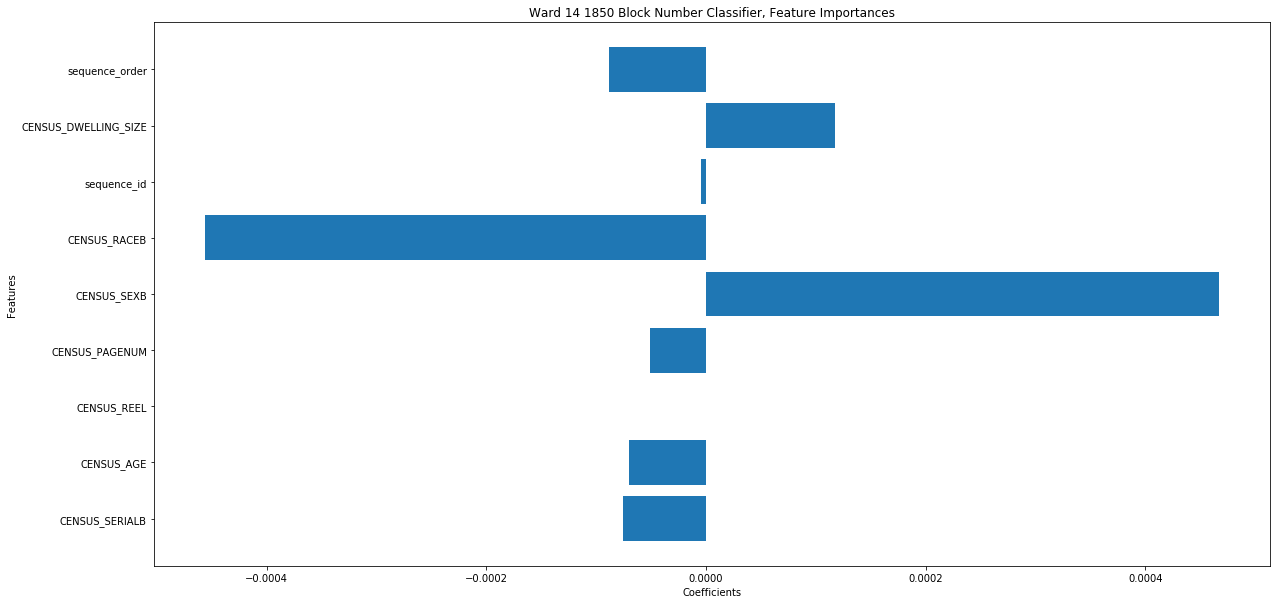

In [79]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order"]
train_X, test_X, train_y, test_y = train_test_split(ward_14.loc[:,all_cols], ward_14.loc[:, "block_num"])
ridge_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', RidgeClassifier(alpha = 10000))])
ridge_class.fit(train_X, train_y)
print("Model Trained for Ward " + str(ward))
print("Training Score:", ridge_class.score(train_X, train_y))
print("1850 Test Score:", ridge_class.score(test_X, test_y))
interpolation.graph_coefs(ridge_class.named_steps['preprocess'].get_feature_names(), ridge_class.named_steps['classifier'].coef_[0], "Ward 14 1850 Block Number Classifier, Feature Importances")

Model Trained for Ward 19.0
Training Score: 0.256898358365351
1850 Test Score: 0.24332111052907282


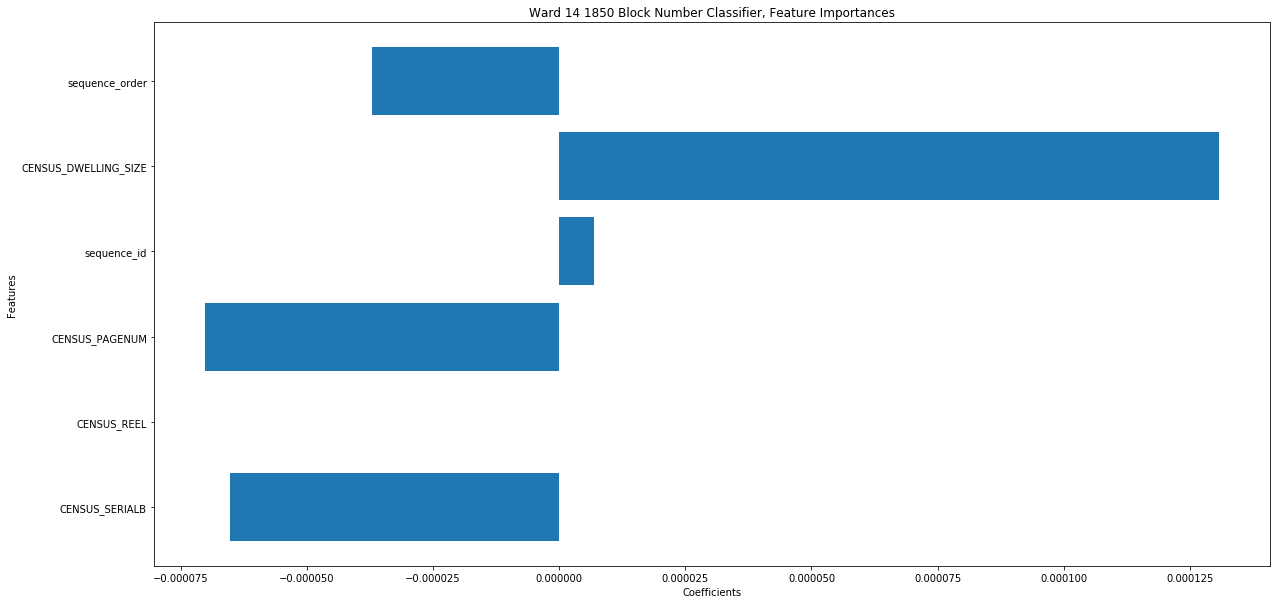

In [82]:
nodem = ["CENSUS_SERIALB", "CENSUS_REEL", "CENSUS_PAGENUM", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order"]
train_X, test_X, train_y, test_y = train_test_split(ward_14.loc[:,nodem], ward_14.loc[:, "block_num"])
ridge_class = Pipeline([('preprocess', TargetEncoder(cols = nodem)),
                         ('classifier', RidgeClassifier(alpha = 10000))])
ridge_class.fit(train_X, train_y)
print("Model Trained for Ward " + str(ward))
print("Training Score:", ridge_class.score(train_X, train_y))
print("1850 Test Score:", ridge_class.score(test_X, test_y))
interpolation.graph_coefs(ridge_class.named_steps['preprocess'].get_feature_names(), ridge_class.named_steps['classifier'].coef_[0], "Ward 14 1850 Block Number Classifier, Feature Importances")

In [85]:
print("dwelling score:",ridge_class.score(dwelling_ward_14.loc[:,nodem], dwelling_ward_14.loc[:,"block_num"]))

dwelling score: 0.20950323974082075


So it seems that including demographic information seems to help a bit, but it's unclear to what extent. I think we also need to ask whether there is another way to solve this problem? What can we do to automate this without ML? And will that work better
And how can we fine tune, I think including a geographic aspects of the block numbers into the loss function would help.

In [3]:
# let's try gradient boosting
from xgboost import XGBClassifier
from xgboost import plot_tree

In [96]:
train_X, test_X, train_y, test_y = train_test_split(ward_14.loc[:,all_cols], ward_14.loc[:, "block_num"])
block_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier())])
block_class.fit(train_X, train_y)
print("Model Trained for Ward 14")
print("Training Score:", block_class.score(train_X, train_y))
print("1850 Test Score:", block_class.score(test_X, test_y))

Model Trained for Ward 14
Training Score: 1.0
1850 Test Score: 0.9937139863803038


In [97]:
print("dwelling score:",block_class.score(dwelling_ward_14.loc[:,all_cols], dwelling_ward_14.loc[:,"block_num"]))

dwelling score: 0.9892008639308856


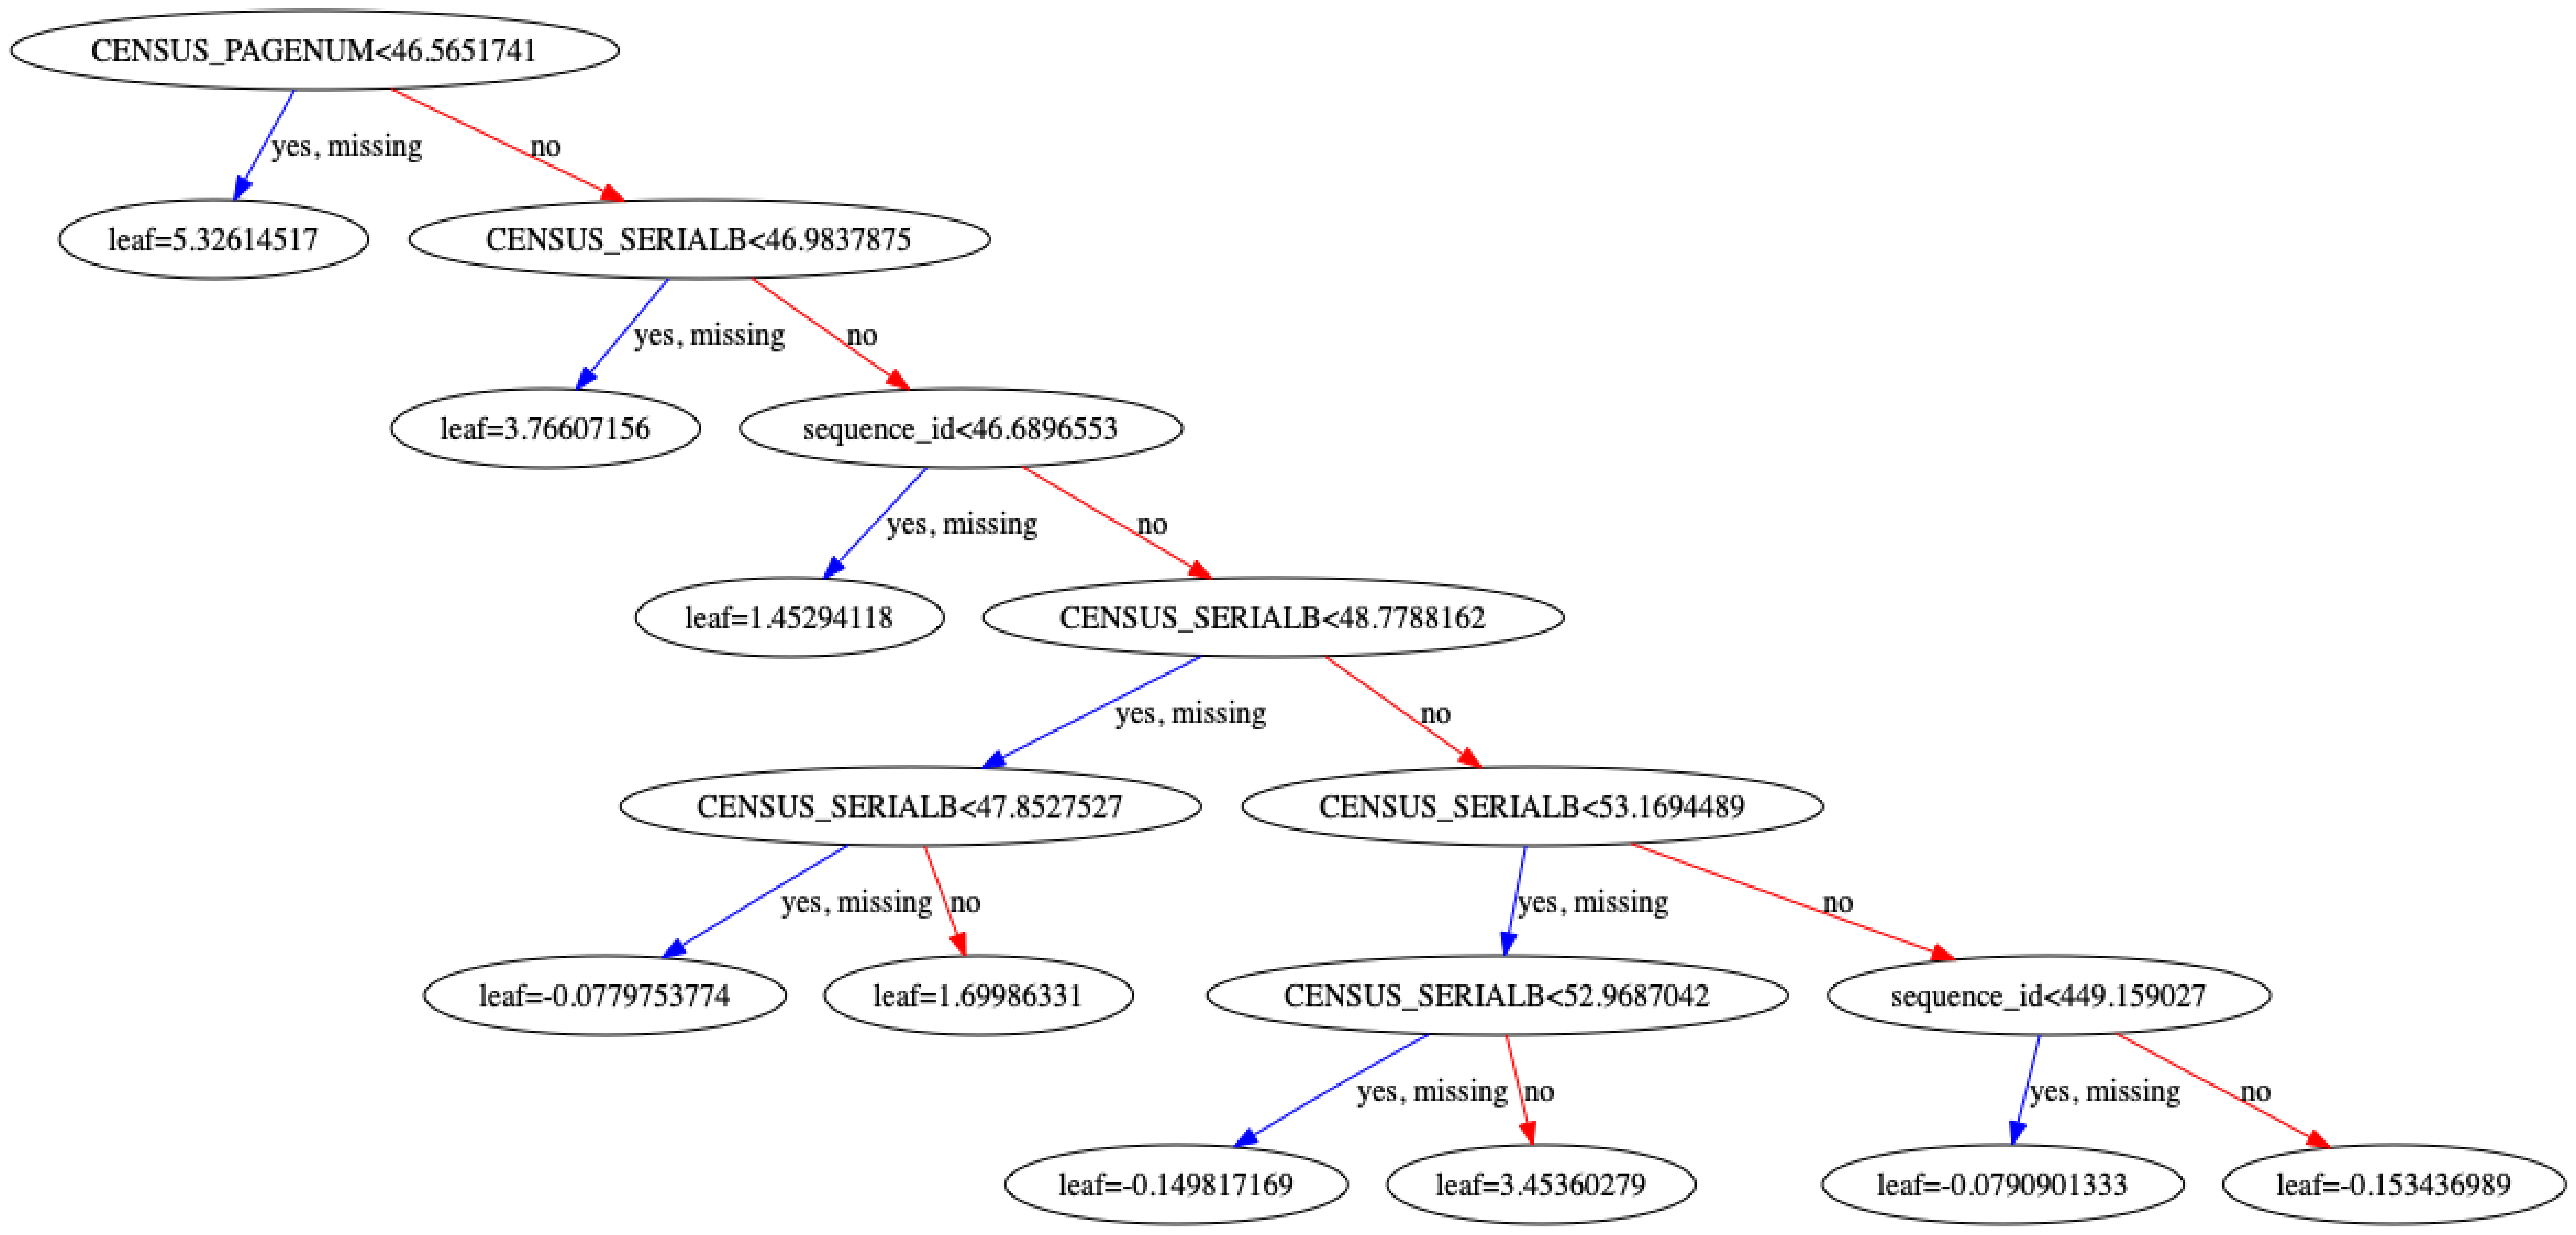

In [98]:
plot_tree(block_class.named_steps["classifier"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

So that clearly worked really, really well. Let's try it for all the wards and see what we end up with.

In [100]:
#note training on dwellings causes extreme overfitting
for ward in dwellings_1850.WARD_NUM.unique():
    df_dwellings = dwellings_1850[dwellings_1850["WARD_NUM"] == ward]
    df = census_1850_model[census_1850_model["WARD_NUM"] == ward]
    train_X, test_X, train_y, test_y = train_test_split(df.loc[:,all_cols], df.loc[:, "block_num"])
    block_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier())])
    block_class.fit(train_X, train_y)
    print("Model Trained for Ward " + str(ward))
    print("Training Score:", block_class.score(train_X, train_y))
    print("1850 Test Score:", block_class.score(test_X, test_y))
    print("Dwelling Score:", block_class.score(df_dwellings.loc[:,all_cols], df_dwellings.loc[:,"block_num"]), "\n")

Model Trained for Ward 1.0
Training Score: 1.0
1850 Test Score: 0.9994088087496305
Dwelling Score: 1.0 

Model Trained for Ward 2.0
Training Score: 1.0
1850 Test Score: 0.9958563535911602
Dwelling Score: 1.0 

Model Trained for Ward 3.0
Training Score: 1.0
1850 Test Score: 0.9957142857142857
Dwelling Score: 1.0 

Model Trained for Ward 4.0
Training Score: 1.0
1850 Test Score: 0.9960831575775836
Dwelling Score: 0.9826086956521739 

Model Trained for Ward 5.0
Training Score: 1.0
1850 Test Score: 0.9902576995600252
Dwelling Score: 0.9921568627450981 

Model Trained for Ward 6.0
Training Score: 1.0
1850 Test Score: 0.9967458509599739
Dwelling Score: 0.9966887417218543 

Model Trained for Ward 7.0
Training Score: 1.0
1850 Test Score: 0.9975409836065574
Dwelling Score: 0.9967532467532467 

Model Trained for Ward 8.0
Training Score: 1.0
1850 Test Score: 0.9931069266980498
Dwelling Score: 0.9954954954954955 

Model Trained for Ward 9.0
Training Score: 1.0
1850 Test Score: 0.9938981126720591
Dw

In [101]:
# So this clearly works really well, so well I find it a little concerning
ward_19 = census_1850_model[census_1850_model["WARD_NUM"] == 19]
print(ward_19.groupby('CENSUS_DWELLING_NUM').ngroups)

3


In [103]:
# let's look closely at how many dwellings we actually have in each ward
for ward in dwellings_1850.WARD_NUM.unique():
    df = census_1850_model[census_1850_model["WARD_NUM"] == ward]
    print("Dwellings in ward " + str(ward), df.groupby('CENSUS_DWELLING_NUM').ngroups)

Dwellings in ward 1.0 302
Dwellings in ward 2.0 105
Dwellings in ward 3.0 127
Dwellings in ward 4.0 345
Dwellings in ward 5.0 510
Dwellings in ward 6.0 302
Dwellings in ward 7.0 616
Dwellings in ward 8.0 666
Dwellings in ward 9.0 813
Dwellings in ward 10.0 378
Dwellings in ward 11.0 329
Dwellings in ward 13.0 557
Dwellings in ward 14.0 463
Dwellings in ward 15.0 400
Dwellings in ward 16.0 864
Dwellings in ward 17.0 464
Dwellings in ward 18.0 280
Dwellings in ward 19.0 3


These are definitely small datasets, but aside from ward 19 not absurd I think. Let's look at the entire dataset and see what that looks like in terms of the number of dwellings? Despite the high test score, I find myself concerned that the models are memorizing data since there's a lot of different entries within the same dwelling with the same block number, to be fair these entries do have different values in the age and sex categories but those aren't that significant to the model based on the tree visualization. I think something that could be happening is that the model is memorizing the data, and it's working on the test set because the test set contains entries that are very similar to the data already in the training set, particularly in regard to the features the model is paying more attention to. And the fact that the model clearly overfits hugely when training only on the dwelling data supports this idea.

In [135]:
#let's try training on all entries, but doing so in the way that dwellings are separated
#ei if a dwelling is in the training set it's not in the test set
for ward in dwellings_1850.WARD_NUM.unique():
    df = census_1850_model[census_1850_model["WARD_NUM"] == ward]
    dwellings = df.CENSUS_DWELLING_NUM.unique()
    test_set = np.random.choice(dwellings, size = round(len(dwellings)*0.25), replace = False)
    train = df[~df["CENSUS_DWELLING_NUM"].isin(test_set)]
    test = df[df["CENSUS_DWELLING_NUM"].isin(test_set)]
    
    block_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier())])
    block_class.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
    print("Model Trained for Ward " + str(ward))
    print("Training Score:", block_class.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
    print("1850 Test Score:", block_class.score(test.loc[:,all_cols], test.loc[:,"block_num"]), "\n")


Model Trained for Ward 1.0
Training Score: 1.0
1850 Test Score: 0.02224199288256228 

Model Trained for Ward 2.0
Training Score: 1.0
1850 Test Score: 0.027906976744186046 

Model Trained for Ward 3.0
Training Score: 1.0
1850 Test Score: 0.0389321468298109 

Model Trained for Ward 4.0
Training Score: 1.0
1850 Test Score: 0.21263989466754443 

Model Trained for Ward 5.0
Training Score: 1.0
1850 Test Score: 0.2452536570183629 

Model Trained for Ward 6.0
Training Score: 1.0
1850 Test Score: 0.19509125235997482 

Model Trained for Ward 7.0
Training Score: 1.0
1850 Test Score: 0.3273260687342833 

Model Trained for Ward 8.0
Training Score: 1.0
1850 Test Score: 0.23182874211749088 

Model Trained for Ward 9.0
Training Score: 1.0
1850 Test Score: 0.1735191637630662 

Model Trained for Ward 10.0
Training Score: 1.0
1850 Test Score: 0.21077383497221033 

Model Trained for Ward 11.0
Training Score: 1.0
1850 Test Score: 0.11457122937485476 

Model Trained for Ward 13.0
Training Score: 1.0
1850 Te

In [132]:
census_1850_all = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
for ward in census_1850_all.CENSUS_WARD_NUM.unique():
    df = census_1850_all[census_1850_all["CENSUS_WARD_NUM"] == ward]
    print("Dwellings in ward " + str(ward), df.groupby('CENSUS_DWELLING_NUM').ngroups)

Dwellings in ward 1 577
Dwellings in ward 2 424
Dwellings in ward 3 681
Dwellings in ward 4 760
Dwellings in ward 5 1034
Dwellings in ward 6 711
Dwellings in ward 7 1189
Dwellings in ward 8 1075
Dwellings in ward 9 1337
Dwellings in ward 10 1041
Dwellings in ward 11 1048
Dwellings in ward 12 1049
Dwellings in ward 13 972
Dwellings in ward 14 937
Dwellings in ward 15 1133
Dwellings in ward 16 1875
Dwellings in ward 17 1062
Dwellings in ward 18 1149
Dwellings in ward 19 1771


There are definitely some concerns with this approach, namely -- are all block numbers represented within the dataset? My guess is no -- that means the model will likely skew to classifying based on blocks that are represented within the known data. How can we incorporate the geographic aspect of this process better? Something else to consider are the effects of the revisions being made up the pipeline -- we might end up with more CD-Census links that allow us to comment more on the data. Maybe it will help to understand how the blocks are laid out in this year better -- to get a sense of the geographic aspect? One way to deal with this is to bin blocks that have very few/no data together under a single label. That way we'll end up with a subset of data that we know the model doesn't have the information to deal with and we can look at it more closely instead of simply labeling it incorrectly? 

Next steps:
1. Try training a model that works when tested on dwellings that don't occur in training set
2. Look at the results with some of the checking done for street numbers, get a sense of whether it's working as expected for unknown data that we can feel relatively confident about the block numbers for
3. Try to evaluate the extent of the imbalanced data problem

In [7]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_REEL", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE", "sequence_order"]
dwelling_ward_14 = census_1850_model[census_1850_model["WARD_NUM"] == 14.0].copy()

In [11]:
test_set = np.random.choice(dwelling_ward_14.CENSUS_DWELLING_NUM.unique(), size = round(len(dwelling_ward_14.CENSUS_DWELLING_NUM.unique())*0.25), replace = False)
train = dwelling_ward_14[~dwelling_ward_14["CENSUS_DWELLING_NUM"].isin(test_set)]
test = dwelling_ward_14[dwelling_ward_14["CENSUS_DWELLING_NUM"].isin(test_set)]

block_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier())])

block_class.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14")
print("Training Score:", block_class.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14
Training Score: 1.0
1850 Test Score: 0.2460837368271148


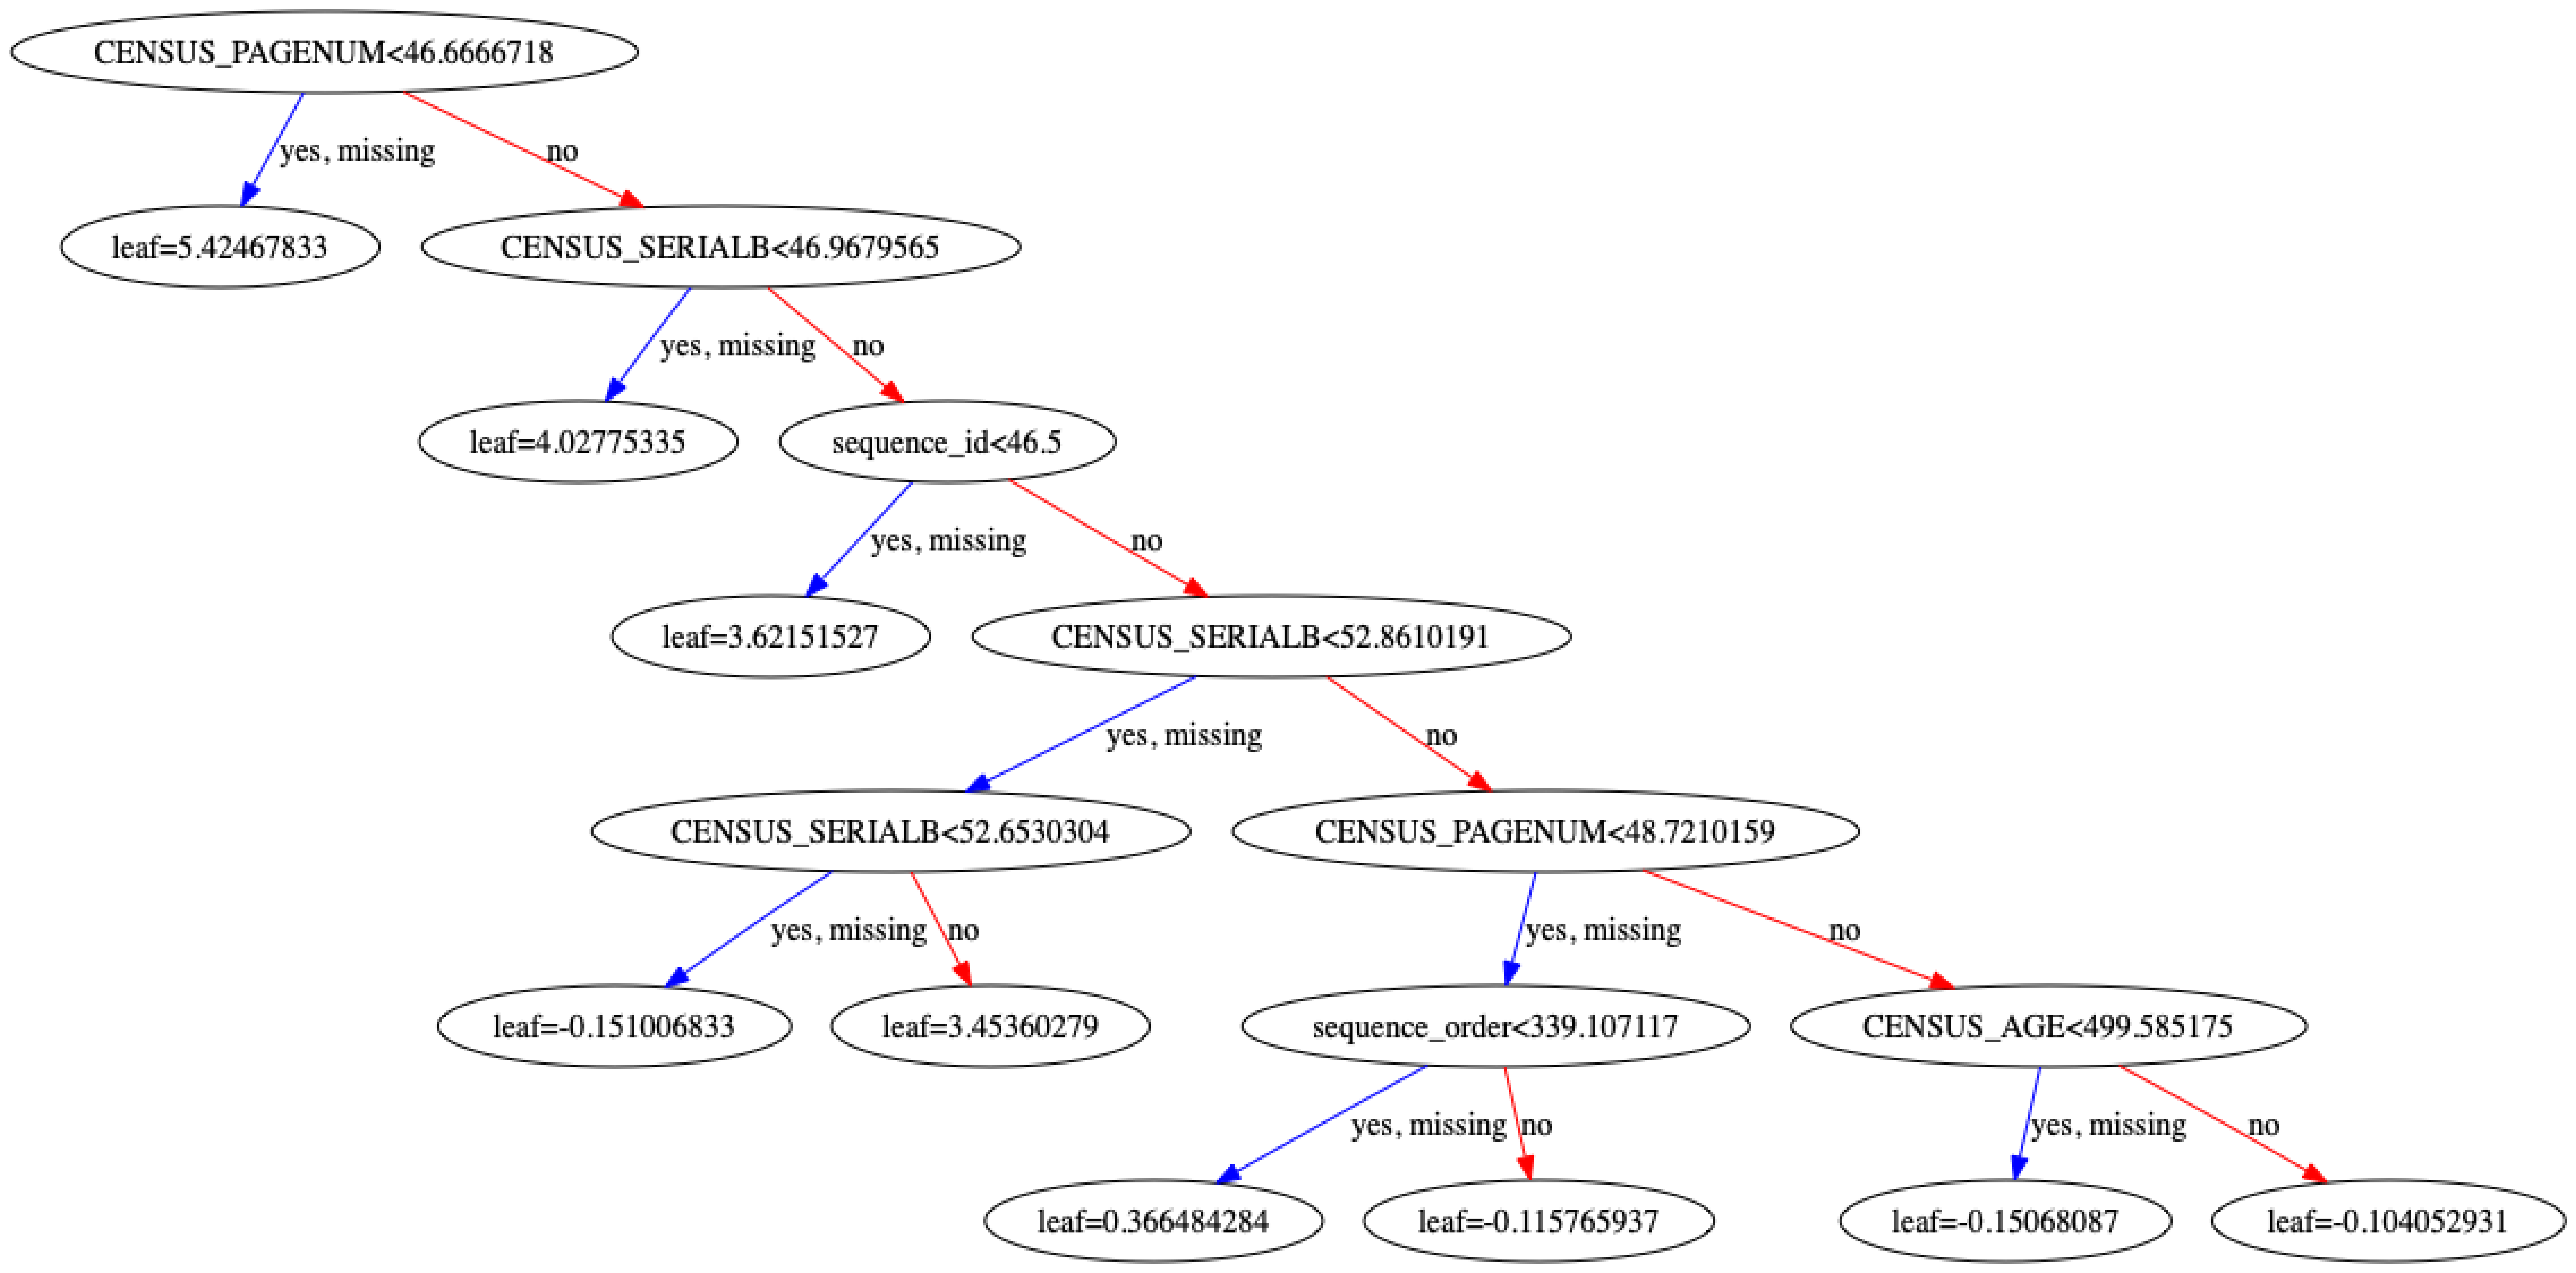

In [12]:
plot_tree(block_class.named_steps["classifier"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

Alright so clearly massive overfitting, let's try adding in some limiting values to help with that process.

In [18]:
block_class = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier(colsample_bytree = 0.7, max_depth = 2, alpha = 3))])

In [25]:
block_class.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14")
print("Training Score:", block_class.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14
Training Score: 0.9992346287949656
1850 Test Score: 0.34007405297636


Next, let's try techniques for dealing with imbalanced datasets namely
1. upsampling (too little data for downsampling), the fact that the whole census data (over just dwellings) helped after subsetting on dwellings gives me hope
2. SMOTE
3. look at how boosting/bagging can be adapted for imbalanced data

#### Simple Upsampling (Caused instability)

In [8]:
from imblearn.over_sampling import RandomOverSampler

In [40]:
test_set = np.random.choice(dwelling_ward_14.CENSUS_DWELLING_NUM.unique(), size = round(len(dwelling_ward_14.CENSUS_DWELLING_NUM.unique())*0.25), replace = False)
train = dwelling_ward_14[~dwelling_ward_14["CENSUS_DWELLING_NUM"].isin(test_set)]
test = dwelling_ward_14[dwelling_ward_14["CENSUS_DWELLING_NUM"].isin(test_set)]

In [41]:
rs = RandomOverSampler()
X_sampled, y_sampled = rs.fit_sample(train.loc[:,all_cols], train.loc[:,"block_num"])

In [42]:
block_class_us = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier(colsample_bytree = 0.7, max_depth = 2, alpha = 3))])

In [38]:
all_data.columns

Index([                     0,           'CD_ADDRESS',                 'CD_X',
                       'CD_Y',           'CENSUS_AGE',          'CENSUS_CITY',
        'CENSUS_DWELLING_NUM',  'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
                'CENSUS_GEOG',        'CENSUS_HH_NUM',            'CENSUS_ID',
              'CENSUS_IMPREL',         'CENSUS_INDEX',     'CENSUS_IPUMS_UID',
            'CENSUS_LABFORCE',          'CENSUS_LINE',         'CENSUS_MARST',
            'CENSUS_NAMEFRST',      'CENSUS_NAMELAST',        'CENSUS_OCCSTR',
             'CENSUS_PAGENUM',         'CENSUS_PLACE',         'CENSUS_RACEB',
                'CENSUS_REEL',       'CENSUS_SEQ_NUM',       'CENSUS_SERIALB',
                'CENSUS_SEXB',             'WARD_NUM',         'house_number',
                'num_between',             'selected',          'sequence_id',
             'sequence_order',       'spatial_weight',   'spatial_weight_sum',
                'street_name'],
      dtype='object'

In [43]:
block_class_us.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14, with Oversampling")
print("Training Score (with oversampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with Oversampling
Training Score (with oversampling): 0.9975198530989913
Training Score: 0.9991320951223746
1850 Test Score: 0.29669156883671294


In [44]:
block_class_us.fit(X_sampled, y_sampled)
print("Model Trained for Ward 14, with Oversampling")
print("Training Score (with oversampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with Oversampling
Training Score (with oversampling): 0.9999761524336441
Training Score: 0.9999132095122375
1850 Test Score: 0.20624332977588047


So this helps other times, sometimes not as much. Further tuning is definitely needed, but I find the lack of stability concerning in terms of getting reliable results. I think part of the problem is that there are some blocks with very very little data (as in a single dwelling in the block). Since we can't have entries from the same dwelling in both the test and training sample (because we won't get reliable results that way), there will likely be limitations in terms of what the model can learn. Let's see if we can try a level of stratified sampling.

#### Stratified Sampling

In [46]:
dwelling_ward_14.groupby("CENSUS_DWELLING_NUM").first().block_num.value_counts()

60.0      70
59.0      28
52.0      26
990.0     24
54.0      23
49.0      22
1010.0    22
1011.0    21
61.0      19
51.0      18
1115.0    15
55.0      14
46.0      13
1133.0    11
1132.0    11
50.0      11
978.0      8
1112.0     8
53.0       7
980.0      7
629.0      7
1116.0     7
117.0      7
48.0       6
985.0      6
977.0      6
987.0      6
47.0       5
979.0      5
988.0      5
981.0      4
982.0      4
989.0      4
984.0      3
1114.0     3
3688.0     3
121.0      3
1113.0     1
Name: block_num, dtype: int64

For right now, I'll simply drop the block with only one dwelling (1113), this is because
I'm not too worried about this right now, because I'm pretty sure that the training set
doesn't include some blocks, but I want to see whether or not this is the sources of the
instability. But this issue (of all the blocks not being represented in the training data is definitely something to keep in mind with this approach)

In [10]:
dwelling_ward_14_dropped = dwelling_ward_14[dwelling_ward_14["block_num"] != 1113]
dwelling_ward_14_dropped.groupby("CENSUS_DWELLING_NUM").first().block_num.value_counts()

60.0      70
59.0      28
52.0      26
990.0     24
54.0      23
1010.0    22
49.0      22
1011.0    21
61.0      19
51.0      18
1115.0    15
55.0      14
46.0      13
50.0      11
1132.0    11
1133.0    11
1112.0     8
978.0      8
53.0       7
117.0      7
980.0      7
1116.0     7
629.0      7
48.0       6
985.0      6
977.0      6
987.0      6
47.0       5
979.0      5
988.0      5
981.0      4
982.0      4
989.0      4
984.0      3
1114.0     3
3688.0     3
121.0      3
Name: block_num, dtype: int64

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
db = dwelling_ward_14_dropped.loc[:,["CENSUS_DWELLING_NUM", 'block_num']].groupby("CENSUS_DWELLING_NUM", as_index = False).first().reset_index(drop = True)
for train, test in StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 123).split(db["CENSUS_DWELLING_NUM"], db["block_num"]):
    train_dwellings = db.loc[train, "CENSUS_DWELLING_NUM"]

In [15]:
train = dwelling_ward_14_dropped[dwelling_ward_14_dropped["CENSUS_DWELLING_NUM"].isin(list(train_dwellings))]
test = dwelling_ward_14_dropped[~dwelling_ward_14_dropped["CENSUS_DWELLING_NUM"].isin(list(train_dwellings))]

In [131]:
rs = RandomOverSampler()
X_sampled, y_sampled = rs.fit_sample(train.loc[:,all_cols], train.loc[:,"block_num"])

In [155]:
block_class_us = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier(colsample_bytree = 0.7, max_depth = 2, alpha = 3, n_estimators = 100))])

In [133]:
block_class_us.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14, with Oversampling")
print("Training Score (with oversampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with Oversampling
Training Score (with oversampling): 0.7802285347379936
Training Score: 0.8400032404407
1850 Test Score: 0.30017452006980805


In [134]:
block_class_us.fit(X_sampled, y_sampled)
print("Model Trained for Ward 14, with Oversampling")
print("Training Score (with oversampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with Oversampling
Training Score (with oversampling): 0.978145325263671
Training Score: 0.9532566429034348
1850 Test Score: 0.2788830715532286


So making a stratified sample is definitely helping with the instability problem, but it clearly shows that upsampling isn't helping. Again, serious tuning is definitely needed, but the bigger problem is, I think that simple upsampling is making the overfitting worse because data is just being duplicated.

#### SMOTE

In [135]:
from imblearn.over_sampling import SMOTE

In [136]:
smote = SMOTE()
X_sampled, y_sampled = smote.fit_sample(train.loc[:,all_cols], train.loc[:,"block_num"])

In [138]:
block_class_us.fit(X_sampled, y_sampled)
print("Model Trained for Ward 14, with SMOTE oversampling")
print("Training Score (with SMOTE oversampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with SMOTE oversampling
Training Score (with SMOTE oversampling): 0.9434370578233314
Training Score: 0.9091866493843163
1850 Test Score: 0.17102966841186737


Well this seems to help with overfitting, but doesn't improve the test score accuracy. Let's try out experimenting with SMOTE with undersampling 

In [143]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipe

In [151]:
smote = SMOTE()
under = RandomUnderSampler()
steps = [('o', smote), ('u', under)]
sampling = imb_pipe(steps = steps)

In [149]:
X_sampled, y_sampled = sampling.fit_resample(train.loc[:,all_cols], train.loc[:,"block_num"])

In [150]:
block_class_us.fit(X_sampled, y_sampled)
print("Model Trained for Ward 14, with SMOTE and undersampling")
print("Training Score (with SMOTE and undersampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with SMOTE and undersampling
Training Score (with SMOTE and undersampling): 0.9502384038239735
Training Score: 0.9128321451717434
1850 Test Score: 0.25759162303664923


So this also failed to really help deal with the situation. Let's try looking at the xgboosting parameters more closely. It's potentially because of increased noise in the dataset? Which may be the reason for the lower training scores too. Let's try a few modified versions of SMOTE and see if they help

In [156]:
from imblearn.over_sampling import SVMSMOTE
smote = SVMSMOTE()
under = RandomUnderSampler()
steps = [('o', smote), ('u', under)]
sampling = imb_pipe(steps = steps)

In [157]:
X_sampled, y_sampled = sampling.fit_resample(train.loc[:,all_cols], train.loc[:,"block_num"])
block_class_us.fit(X_sampled, y_sampled)
print("Model Trained for Ward 14, with SVMSMOTE and undersampling")
print("Training Score (with SVMSMOTE and undersampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, with SVMSMOTE and undersampling
Training Score (with SVMSMOTE and undersampling): 0.9916172221495583
Training Score: 0.9923039533376539
1850 Test Score: 0.218848167539267


In [158]:
block_class_us.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14, on unsampled data")
print("Training Score (with SVMSMOTE and undersampling):", block_class_us.score(X_sampled, y_sampled))
print("Training Score:", block_class_us.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_us.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

Model Trained for Ward 14, on unsampled data
Training Score (with SVMSMOTE and undersampling): 0.9495130854567723
Training Score: 0.998946856772521
1850 Test Score: 0.2917975567190227


#### Xgboost for imbalanced data

In [20]:
block_class_imb = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                         ('classifier', XGBClassifier(max_depth = 2, scale_pos_weight = 3))])

In [21]:
block_class_imb.fit(train.loc[:,all_cols], train.loc[:,"block_num"])
print("Model Trained for Ward 14")
print("Training Score:", block_class_imb.score(train.loc[:,all_cols], train.loc[:,"block_num"]))
print("1850 Test Score:", block_class_imb.score(test.loc[:,all_cols], test.loc[:,"block_num"]))

[18:26:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model Trained for Ward 14
Training Score: 1.0
1850 Test Score: 0.3225130890052356
